## NORC County Analysis and Pattern-Based Clustering

This notebook implements hierarchical clustering analysis on processed NORC (National Opinion Research Center) county-level data. The analysis examines relationships between socioeconomic factors, health indicators, and death rates across U.S. counties, utilizing patterns identified through the AK Analyst Platform.

### Key Components:
- Hierarchical clustering of counties based on multiple features
- Generation of dendrograms showing cluster relationships
- Creation of detailed cluster visualizations
- Analysis of feature distributions within clusters
- Export of cluster data and visualizations

### Data Sources:
- Processed NORC county data (2017-2020)
- Pattern constraints from AK Analyst Platform
- Feature mappings and normalized indicators


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster, to_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import json
from google.colab import drive
from sklearn.cluster import AgglomerativeClustering

drive.mount('/content/drive/')
%cd drive/MyDrive

Mounted at /content/drive/
/content/drive/MyDrive


## Data Loading and Initial Setup
This section loads the preprocessed county data and sets up necessary configurations for clustering analysis. The data includes normalized features from the NORC dataset and pattern information from the AK Analyst Platform.


In [ ]:
# File path to your dataset
file_path = '/content/drive/MyDrive/AP Work/counties from patterns/final_cleaned.csv'

# Load the dataset with error handling to skip problematic rows
try:
    df = pd.read_csv(file_path, on_bad_lines='skip')  # Skip rows with issues
    print("CSV loaded successfully.")
except Exception as e:
    print(f"Error loading CSV: {e}")

# Drop 'Urbanicity' column if it exists
if 'Urbanicity' in df.columns:
    df.drop(columns=['Urbanicity'], inplace=True)


# Replace 'Rural' with 0 and 'Urban' with 1 in 'Urbanicity'
# df['Urbanicity'] = df['Urbanicity'].replace({'Rural': 0, 'Urban': 1})

# Create a combined identifier for each row
df['identifier'] = df['Pattern_id'].astype(str) + ', ' + df['fips'].astype(str)

# Drop non-feature columns to focus on clustering data
features = df.drop(columns=['Pattern_id', 'fips', 'identifier'])

# Extract feature columns for clustering
feature_columns = features.columns.tolist()

# Display a preview of the data
print("Processed data is ready. Here are the first few rows of features:")
print(features.head())


CSV loaded successfully.
Processed data is ready. Here are the first few rows of features:
   Percent-of-Population-Under-15-(2017-2021)  \
0                                        -1.0   
1                                        -1.0   
2                                        -1.0   
3                                        -1.0   
4                                        -1.0   

   Percent-of-Population-Aged-15-to-64-(2017-2021)  \
0                                             -1.0   
1                                             -1.0   
2                                             -1.0   
3                                             -1.0   
4                                             -1.0   

   Percent-of-Population-65+-(2017-2021)  \
0                                   -1.0   
1                                   -1.0   
2                                   -1.0   
3                                   -1.0   
4                                   -1.0   

   Percent-of-Population

## Data Validation
Performing data quality checks and validation:
- Checking for missing values
- Validating feature ranges
- Ensuring proper data formatting


In [ ]:
# Check for NaN values in the entire DataFrame
nan_summary = features.isna().sum()

# Display columns with NaN values and their counts
nan_columns = nan_summary[nan_summary > 0]
if not nan_columns.empty:
    print("Columns with NaN values and their counts:")
    print(nan_columns)
else:
    print("No NaN values found in the DataFrame.")


No NaN values found in the DataFrame.


In [ ]:
# Initialize the number of clusters
n_clusters = 14

# Load the NORC data file for global min and max values
norc_df = pd.read_csv('/content/drive/MyDrive/AP Work/counties from patterns/NORC_data_2017-2020.csv')  # Replace with your actual NORC data file path

# Ensure NORC data has the same features
norc_features = norc_df[feature_columns]

norc_df.head()



fips  Percent-of-Population-Under-15-(2017-2021)  \
0  1001                                      0.1895   
1  1003                                      0.1769   
2  1005                                      0.1719   
3  1007                                      0.1651   
4  1009                                      0.1909   

   Percent-of-Population-Aged-15-to-64-(2017-2021)  \
0                                           0.6591   
1                                           0.6171   
2                                           0.6380   
3                                           0.6745   
4                                           0.6294   

   Percent-of-Population-65+-(2017-2021)  \
0                                 0.1514   
1                                 0.2061   
2                                 0.1901   
3                                 0.1604   
4                                 0.1797   

   Percent-of-Population-White-(non-Hispanic)-(2017-2021)  \
0                                             0.7310        
1                                             0.8257        
2                                             0.4461        
3                                             0.7405        
4                                             0.8592        

   Percent-of-Populaiton-Black-(non-Hispanic)-(2017-2021)  \
0                                             0.1968        
1                                             0.0869        
2                                             0.4725        
3                                             0.2189        
4                                             0.0127        

   Percent-of-Population-Hispanic-or-Latino-(2017-2021)  \
0                                             0.0305      
1                                             0.0468      
2                                             0.0466      
3                                             0.0283      
4                                             0.0953      

   Percent-of-Population-Asian-(non-Hispanic)-(2017-2021)  \
0                                             0.0111        
1                                             0.0096        
2                                             0.0042        
3                                             0.0021        
4                                             0.0037        

   Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2017-2021)  \
0                                             0.0017                                
1                                             0.0047                                
2                                             0.0028                                
3                                             0.0009                                
4                                             0.0012                                

   Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2017-2021)  ...  \
0                                             0.0000                   ...   
1                                             0.0000                   ...   
2                                             0.0000                   ...   
3                                             0.0000                   ...   
4                                             0.0013                   ...   

   Number-of-Substance-Use-Facilities-(As-of-March-2023)  \
0                                                0.0       
1                                                3.0       
2                                                1.0       
3                                                0.0       
4                                                1.0       

   Number-of-Mental-Health-Facilities-(As-of-March-2023)  MDsPerCapita  \
0                                                0.0              3.63   
1                                                1.0              7.52   
2                                                1.0           

## Hierarchical Clustering Implementation
Implementing hierarchical clustering using Ward's method:
- Standardizing features
- Computing linkage matrix
- Determining optimal cluster count
- Generating cluster assignments


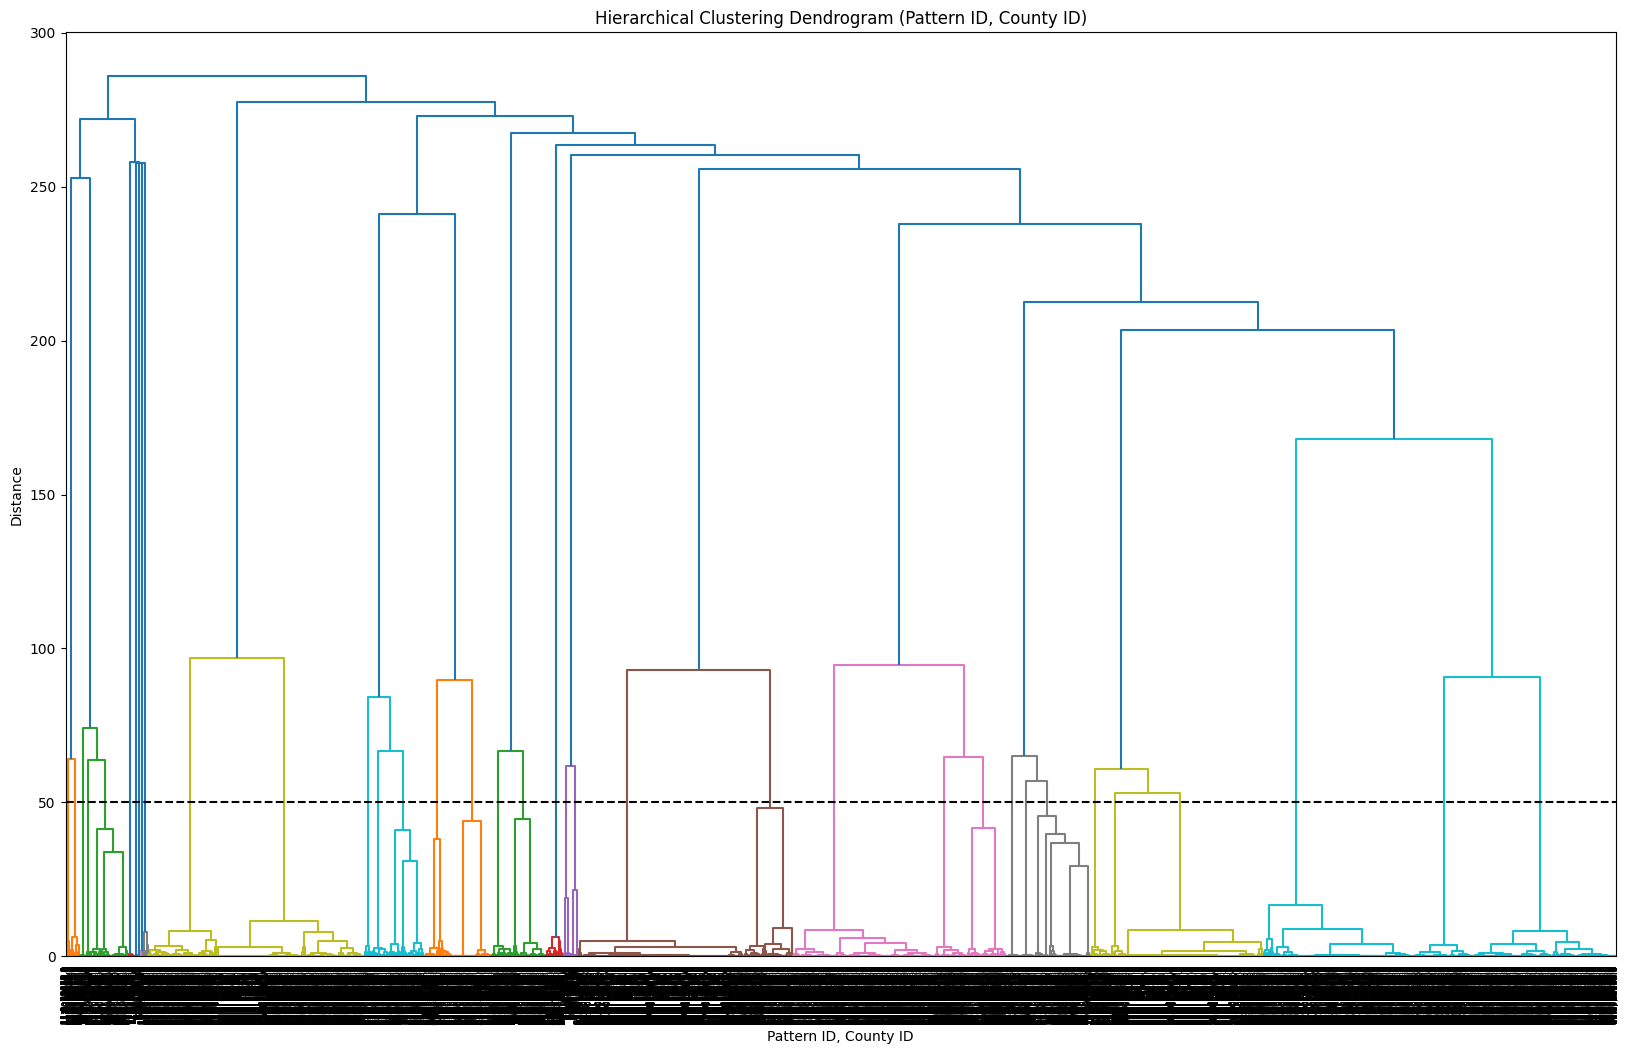

In [ ]:
# Standardize the features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Perform hierarchical clustering using Ward's method
linked = sch.linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(20, 12))
dendrogram = sch.dendrogram(
    linked,
    labels=df['identifier'].values,
    orientation='top',
    leaf_font_size=6,
    color_threshold=None
)

plt.title('Hierarchical Clustering Dendrogram (Pattern ID, County ID)')
plt.xlabel('Pattern ID, County ID')
plt.ylabel('Distance')

# Add a horizontal cut-off line to visualize clusters
# The cut-off distance is determined based on the desired number of clusters
plt.axhline(y=50, color='k', linestyle='--')  # Adjust y-value as needed

plt.show()

# Form clusters based on the desired number of clusters
cluster_labels = fcluster(linked, n_clusters, criterion='maxclust')

# Add cluster labels to the dataframe
df['cluster_label'] = cluster_labels


In [ ]:
# Function to extract the cluster hierarchy
def get_cluster_structure(linkage_matrix, labels):
    tree = to_tree(linkage_matrix, rd=False)
    id_to_cluster = {}

    def add_node(node, parent_id):
        node_id = node.id
        if node.is_leaf():
            cluster_id = labels[node_id]
            id_to_cluster[node_id] = {
                'parent': parent_id,
                'children': [],
                'cluster_id': int(cluster_id),
                'is_leaf': True
            }
        else:
            id_to_cluster[node_id] = {
                'parent': parent_id,
                'children': [node.left.id, node.right.id],
                'is_leaf': False
            }
            add_node(node.left, node_id)
            add_node(node.right, node_id)

    add_node(tree, None)
    return id_to_cluster

cluster_structure = get_cluster_structure(linked, cluster_labels)

# Save cluster_structure to JSON
with open('cluster_structure.json', 'w') as json_file:
    json.dump(cluster_structure, json_file, indent=4)

print("cluster_structure.json has been created.")


cluster_structure.json has been created.


## Visualization Generation
Creating visualizations to understand cluster characteristics:
- Generating dendrograms
- Creating feature distribution plots
- Producing cluster histograms


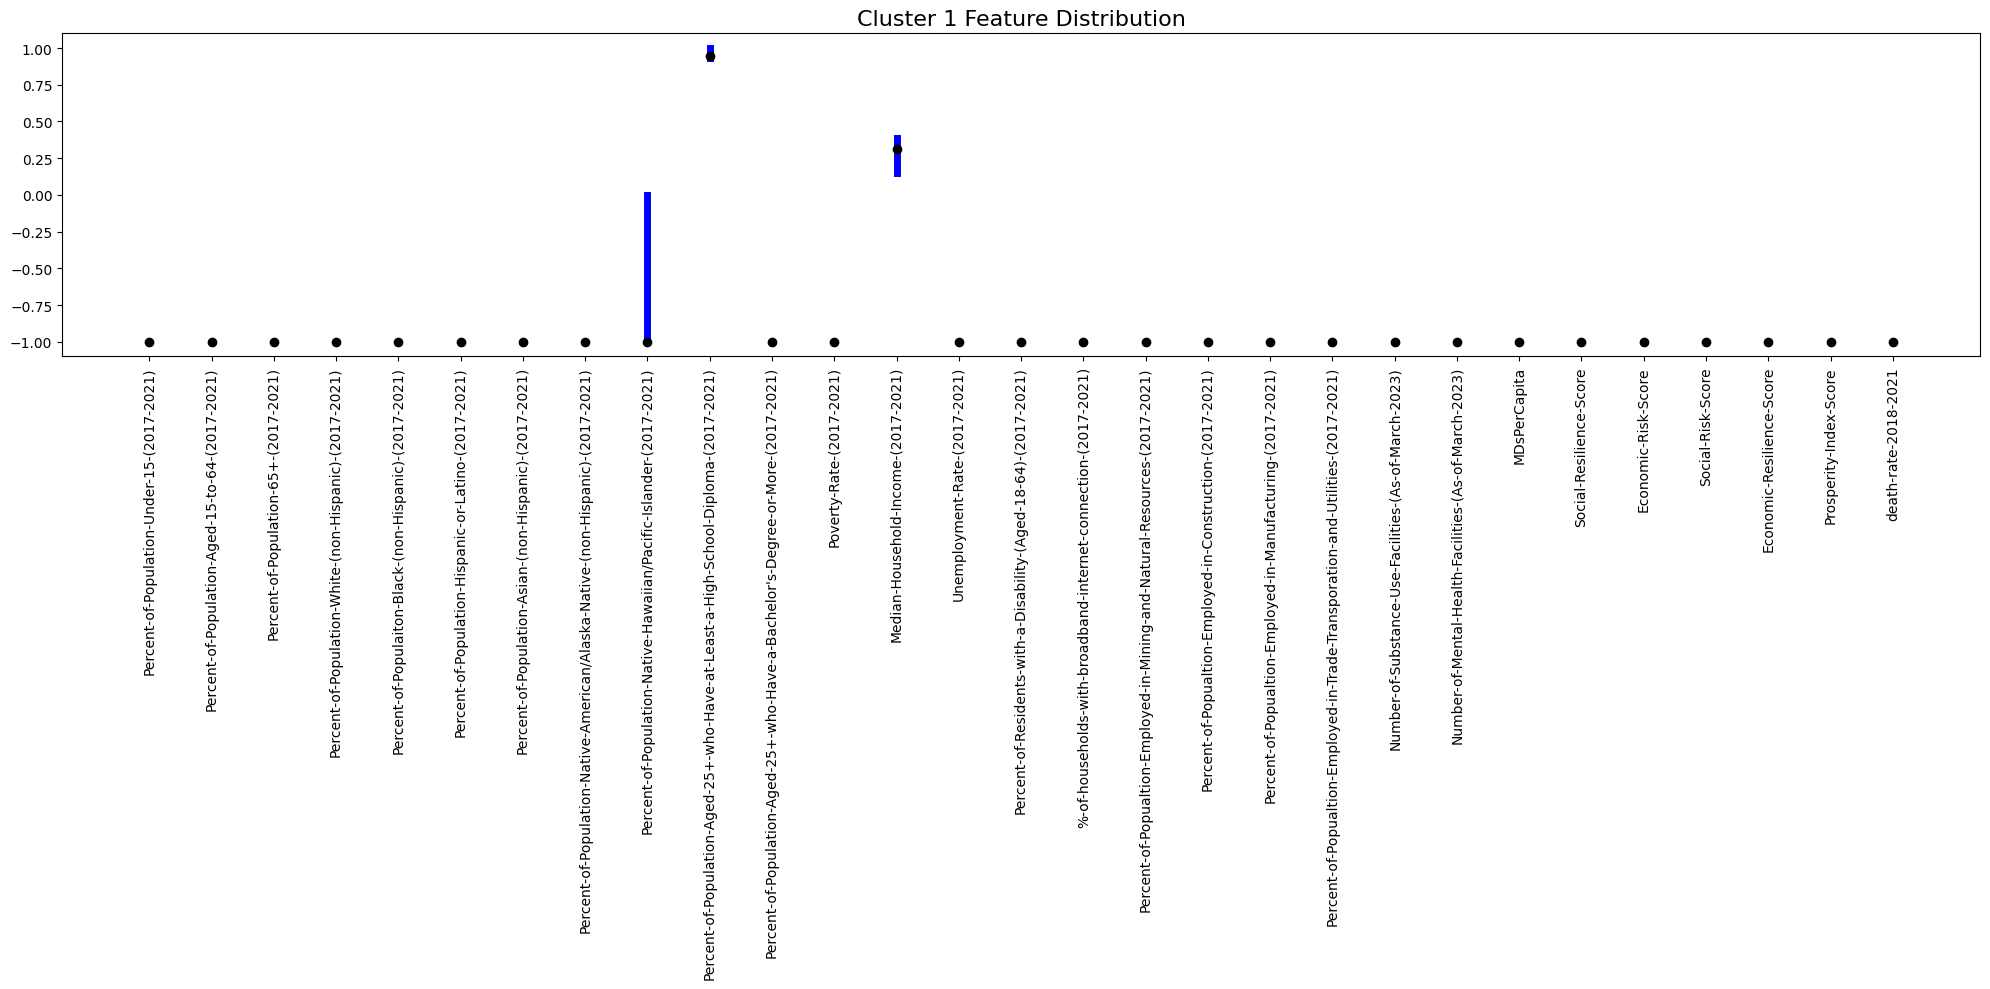

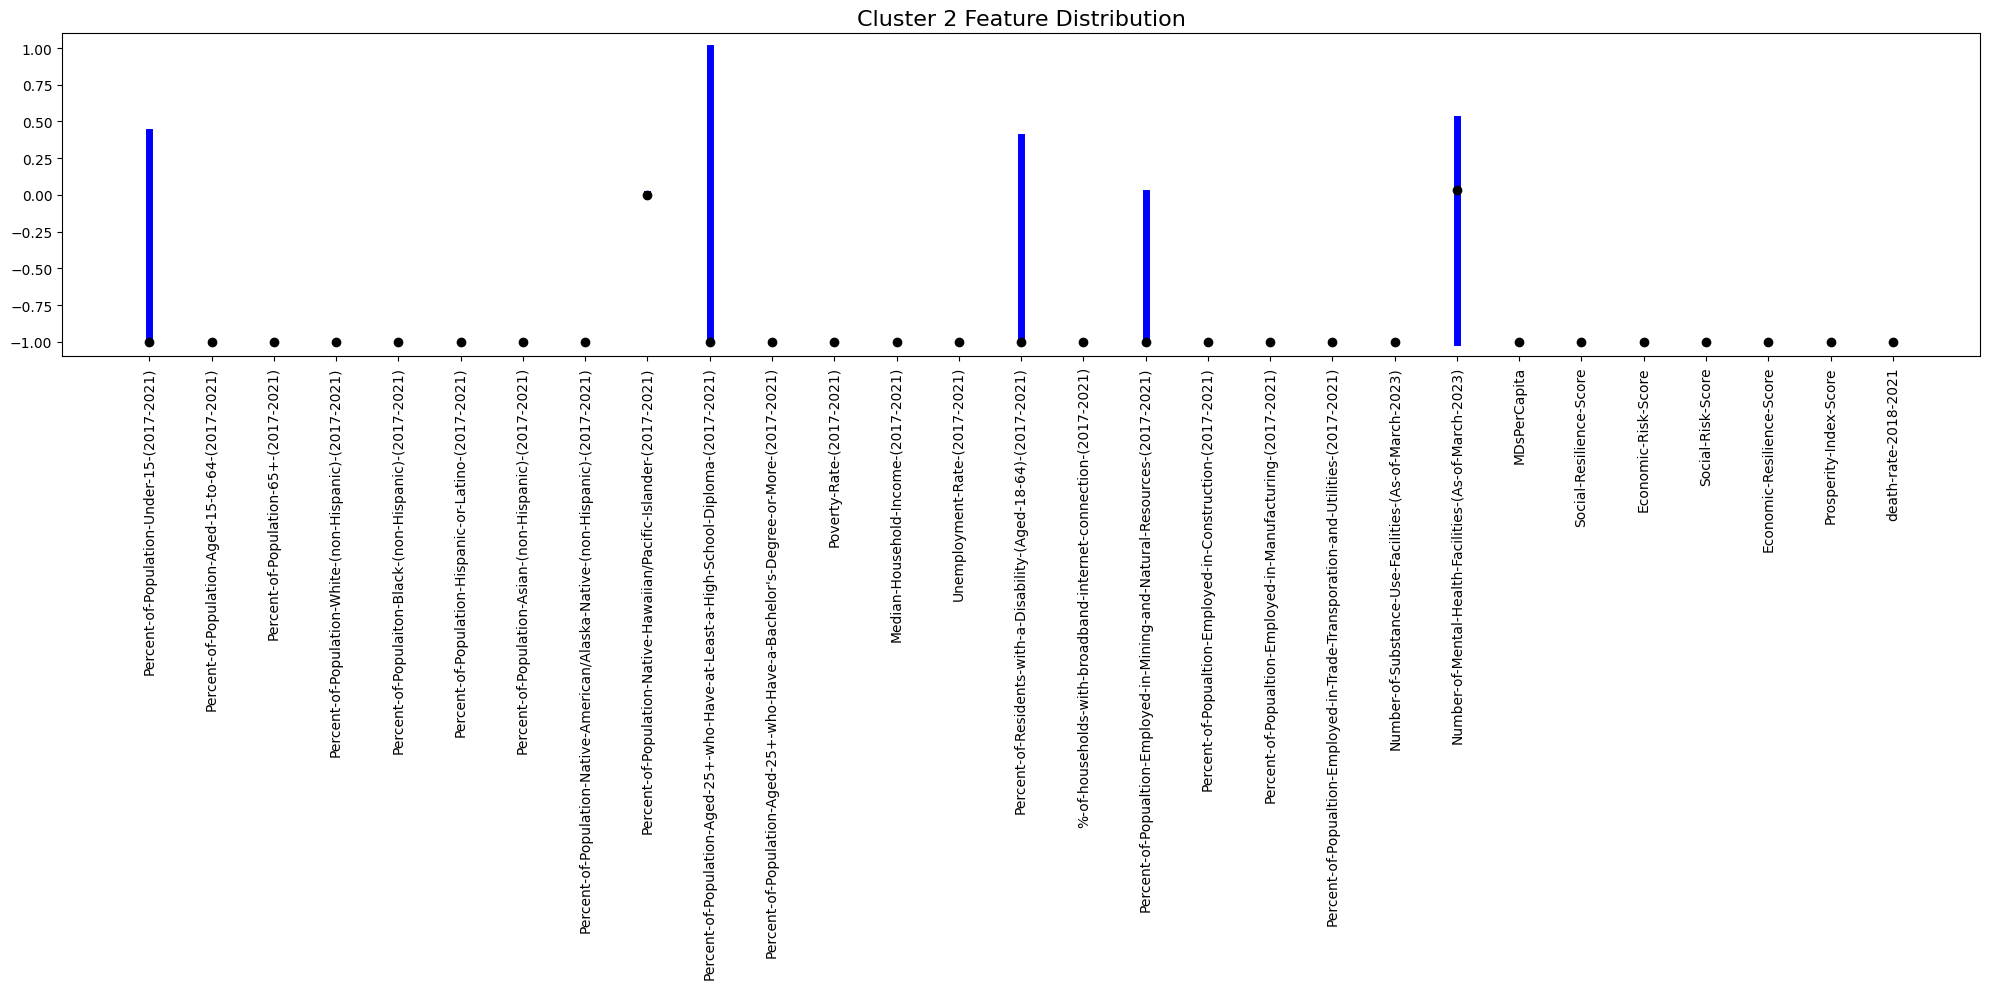

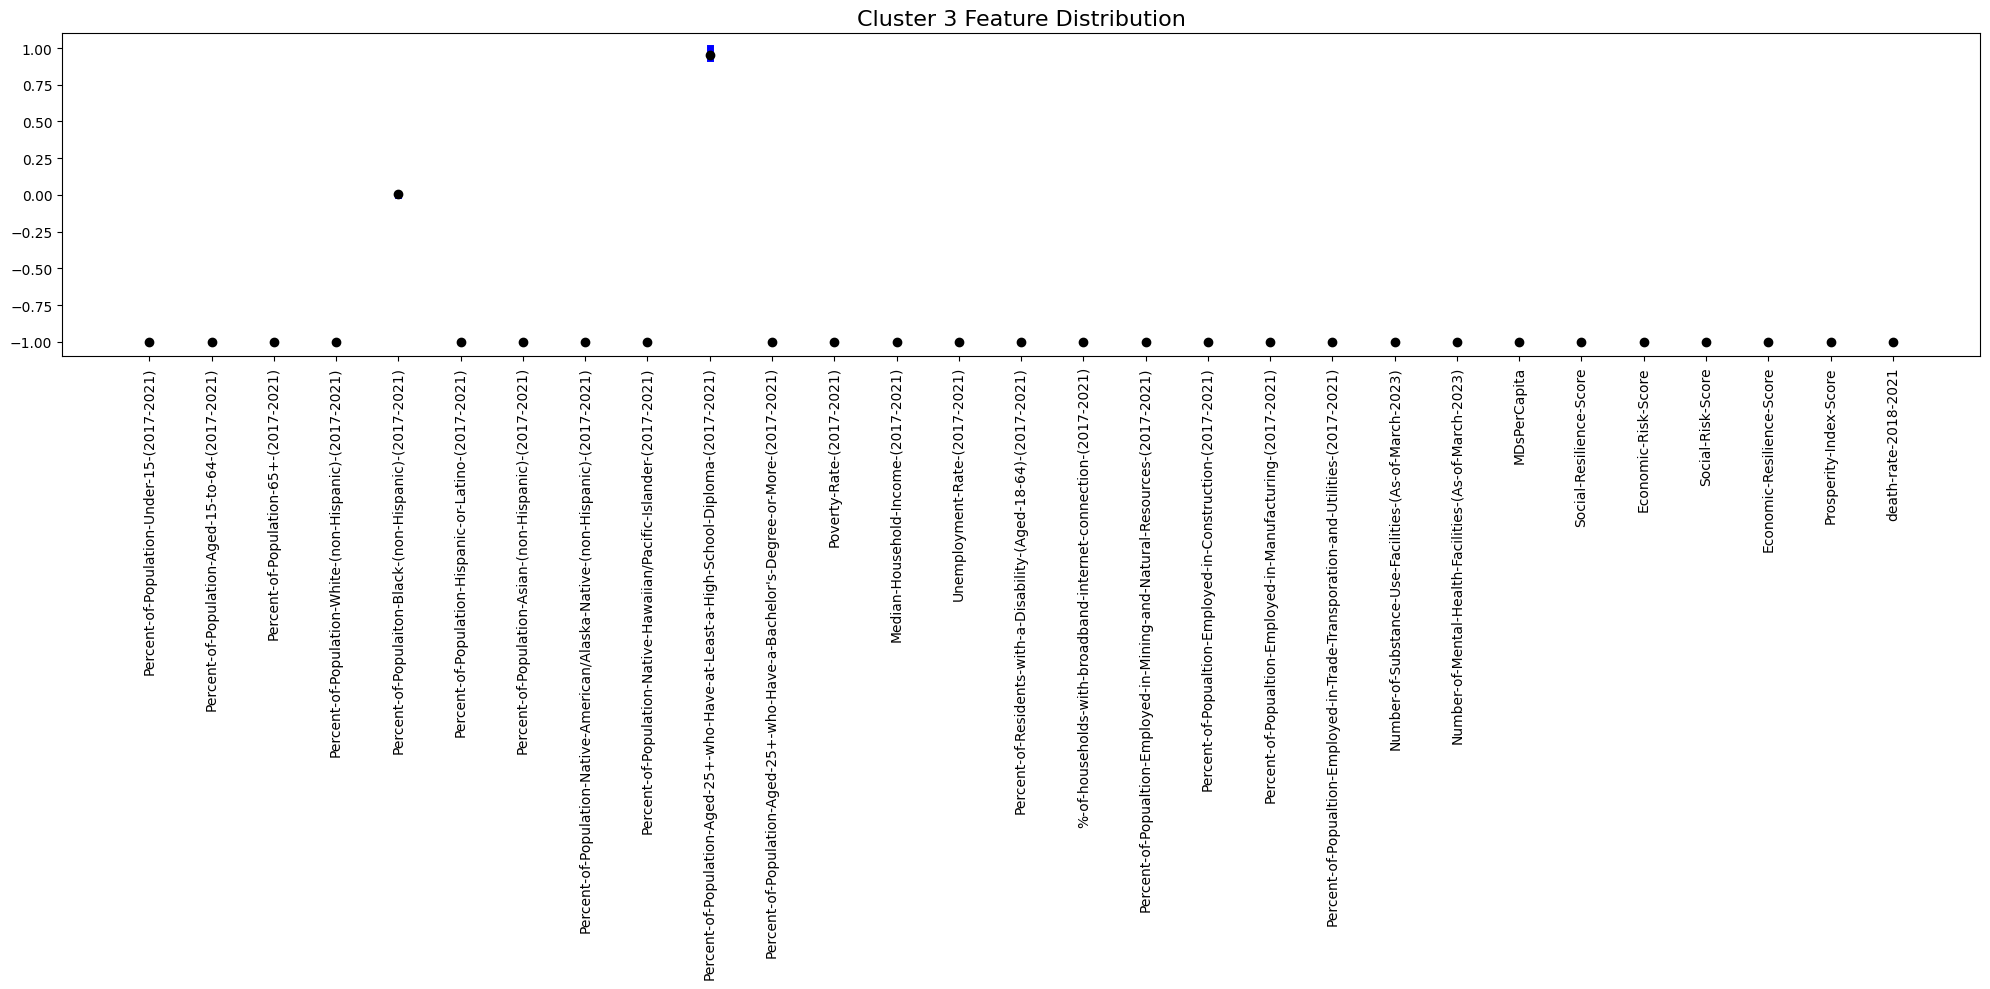

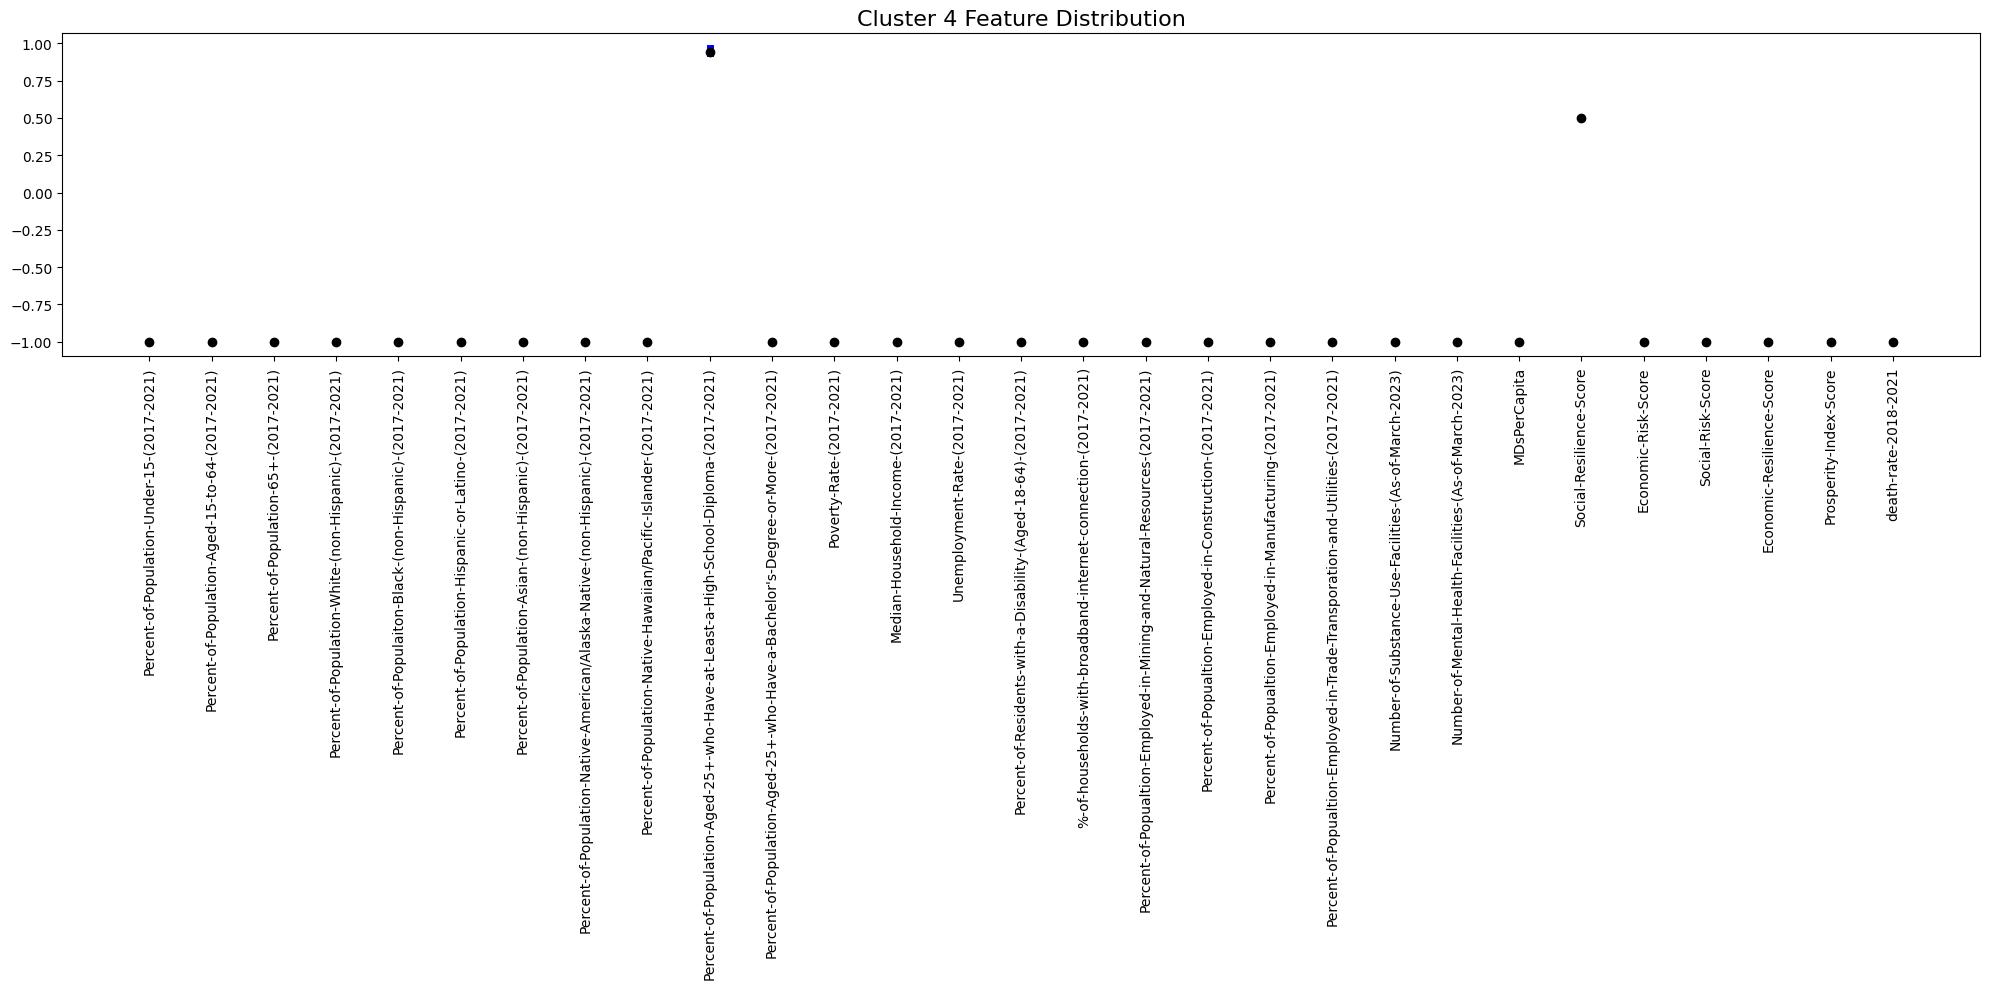

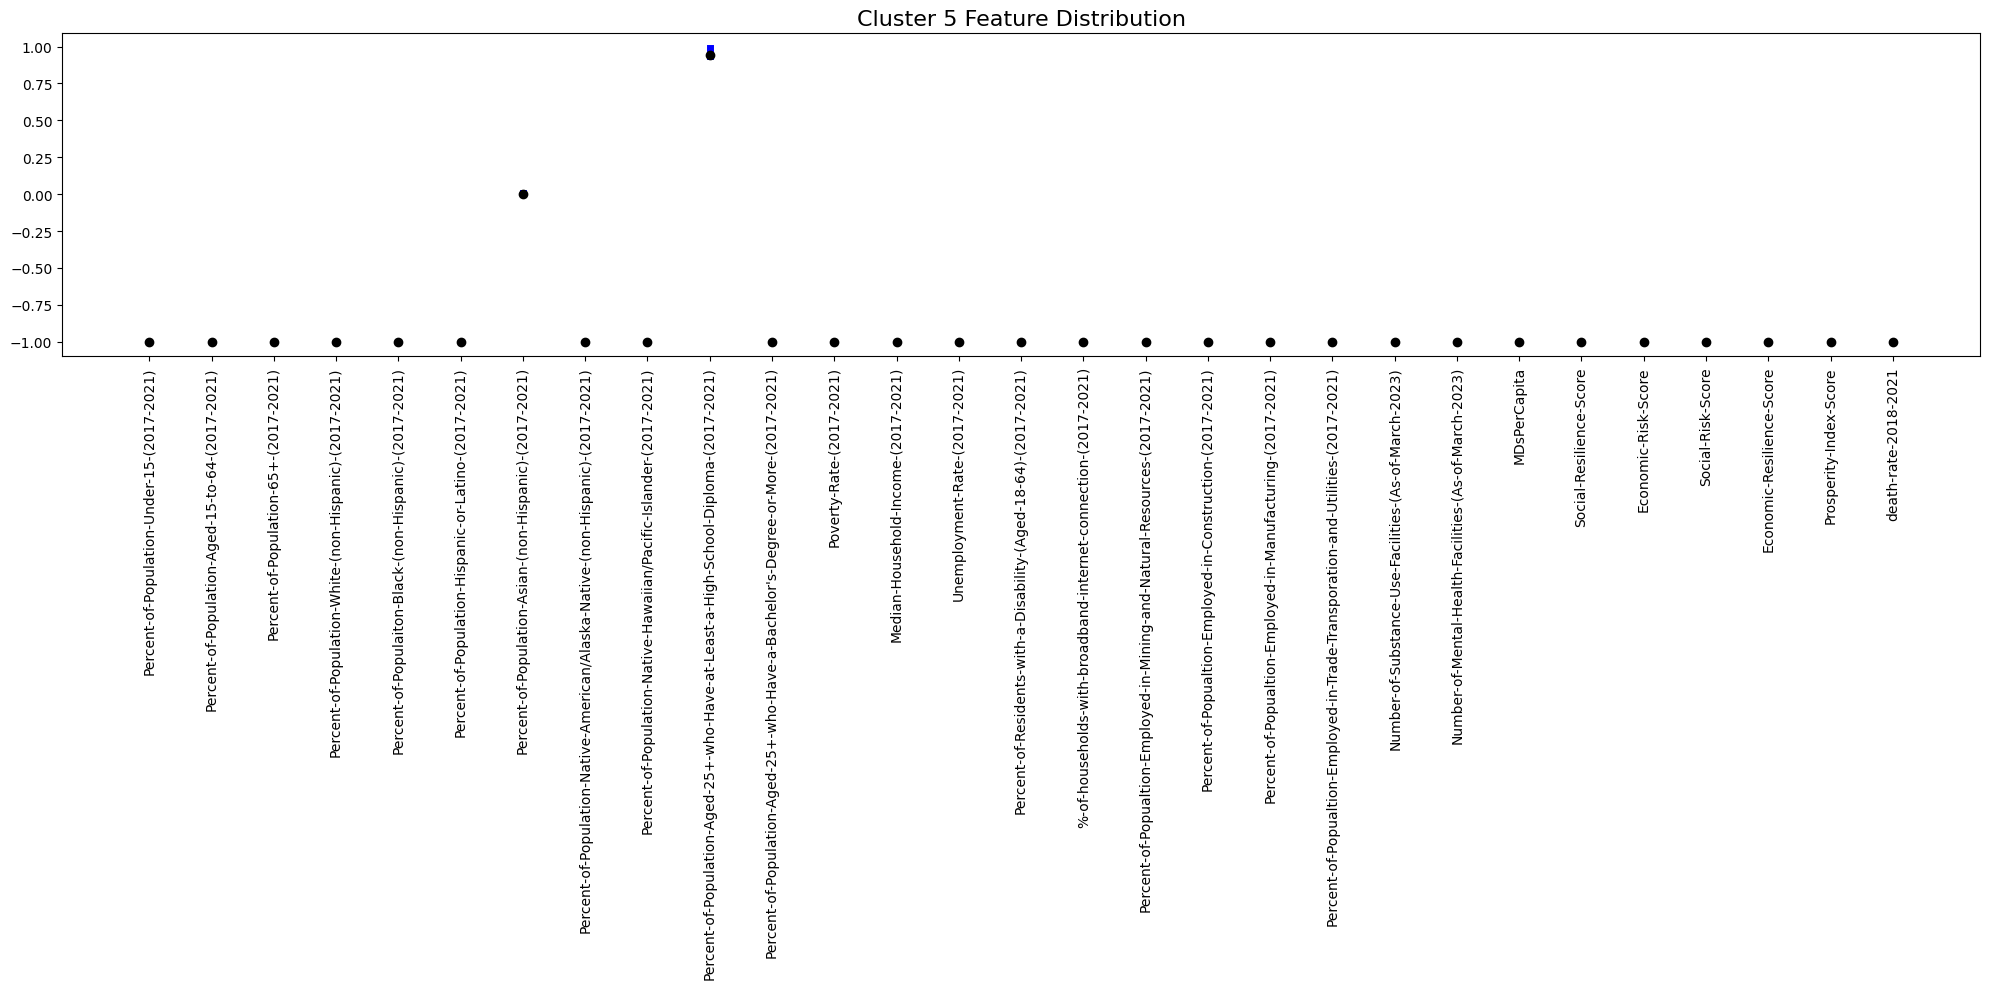

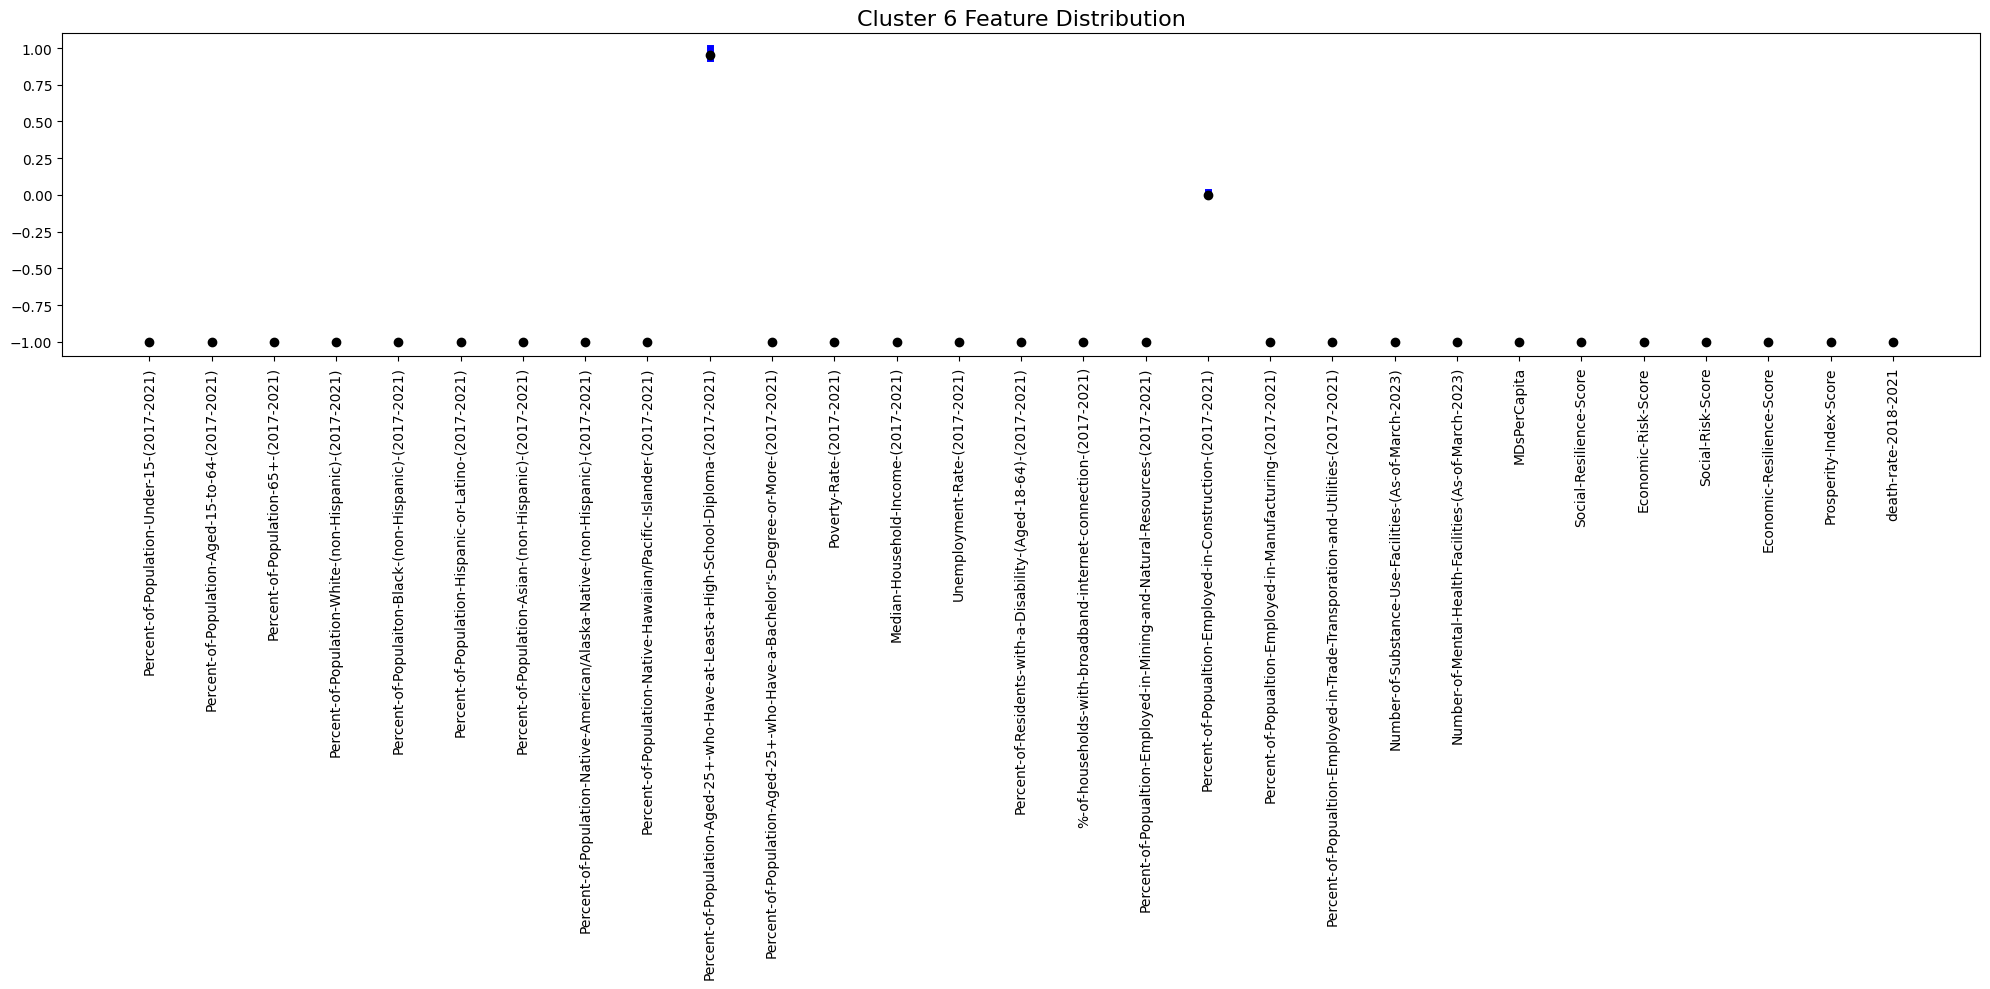

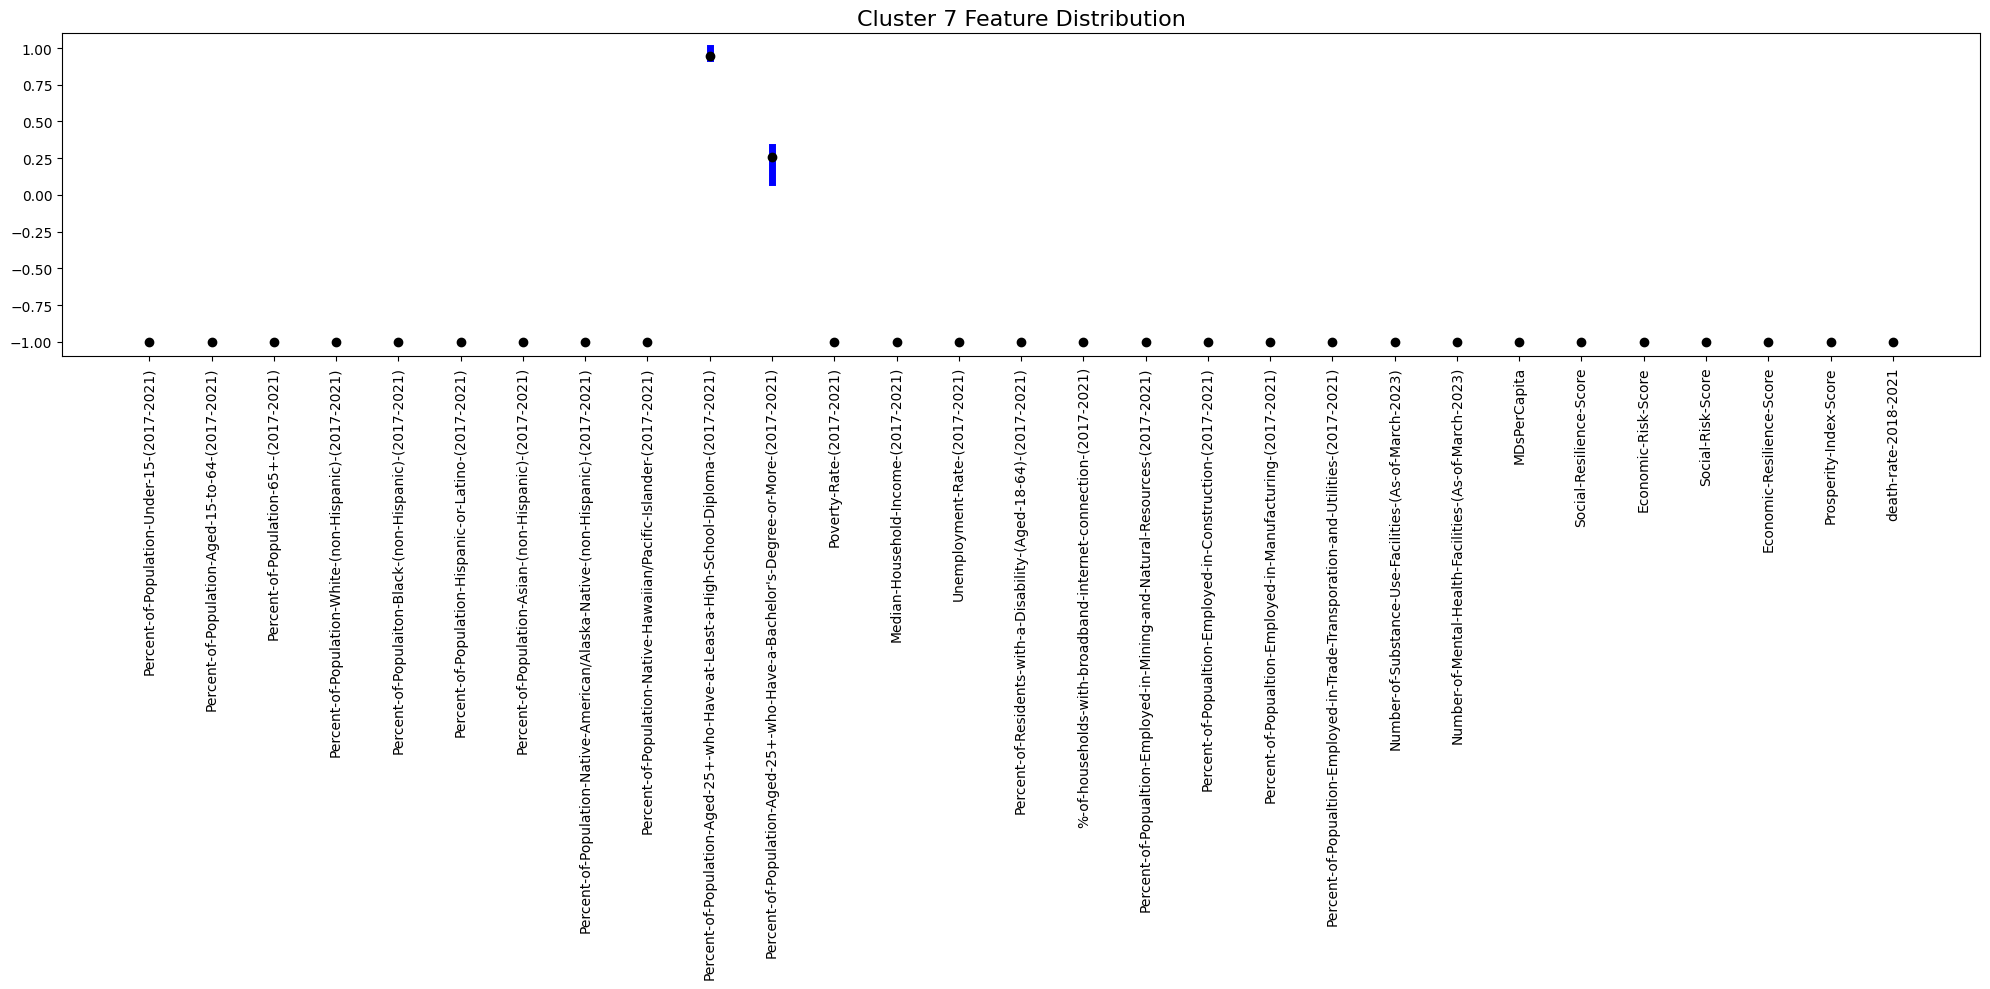

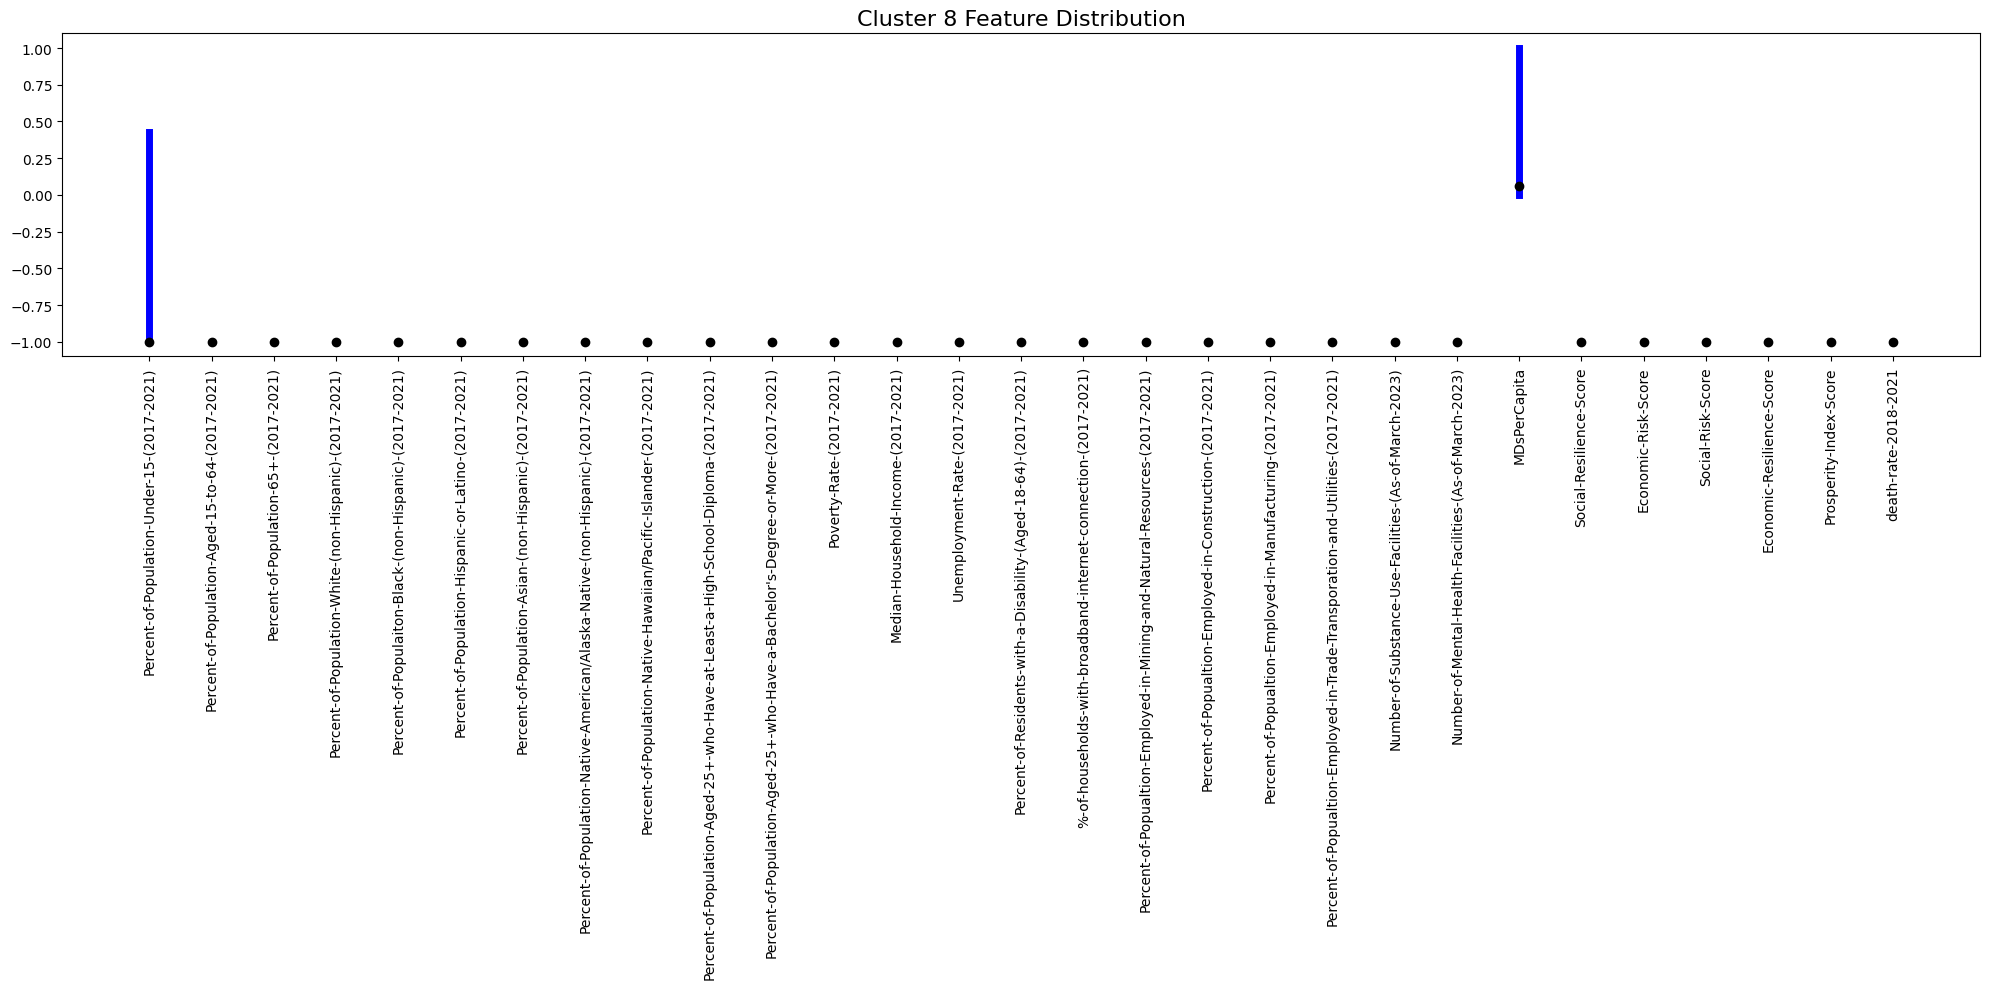

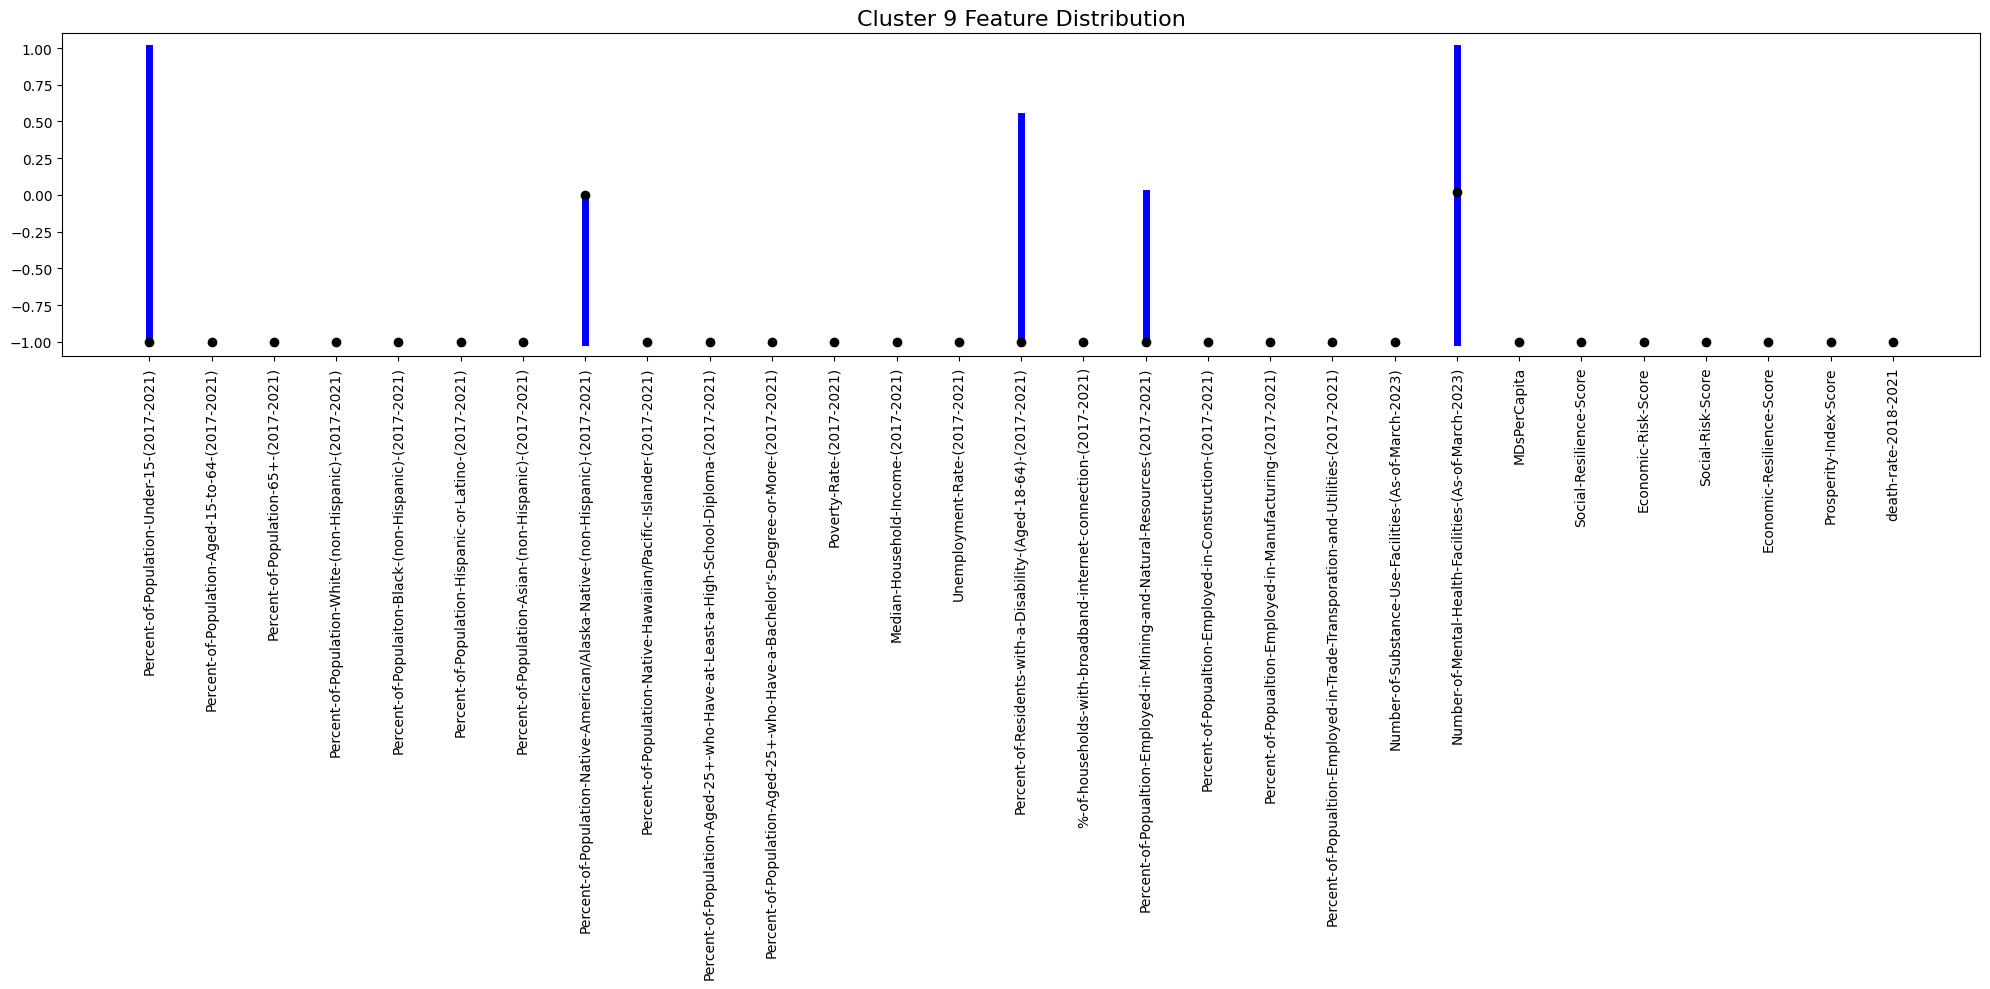

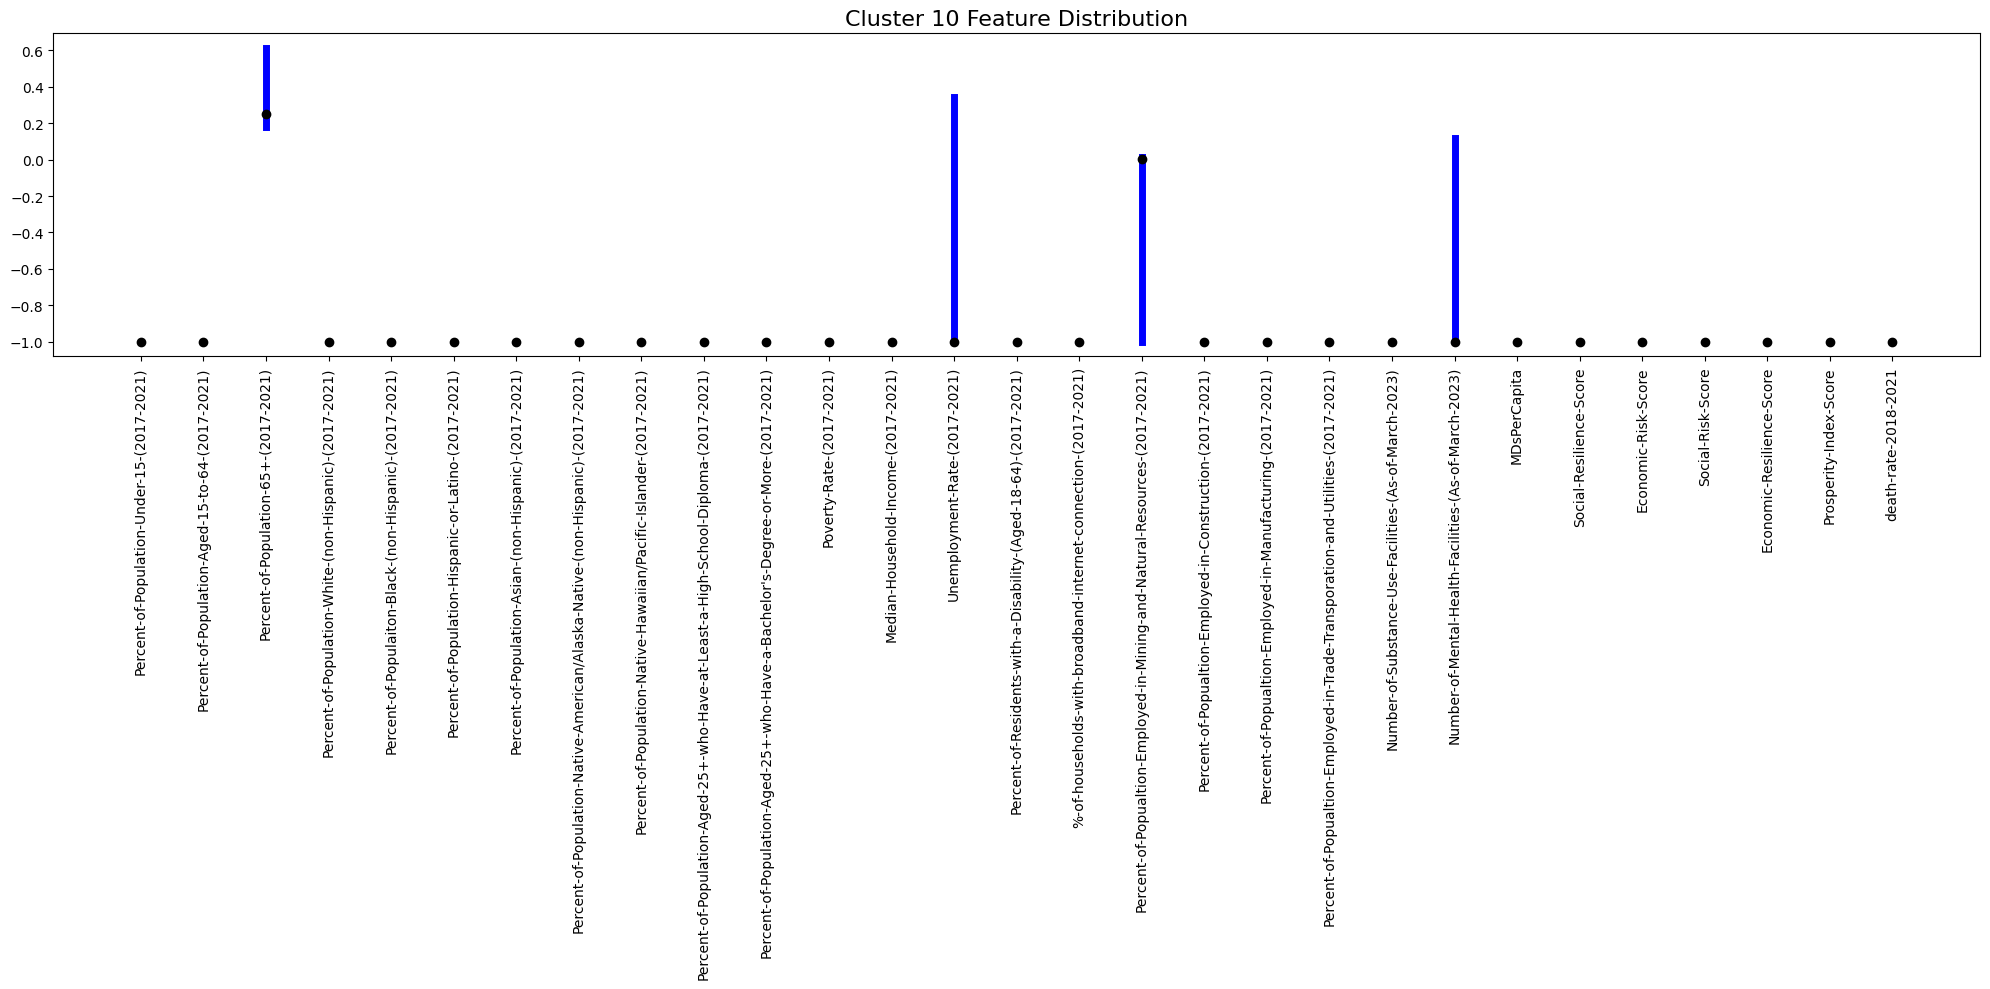

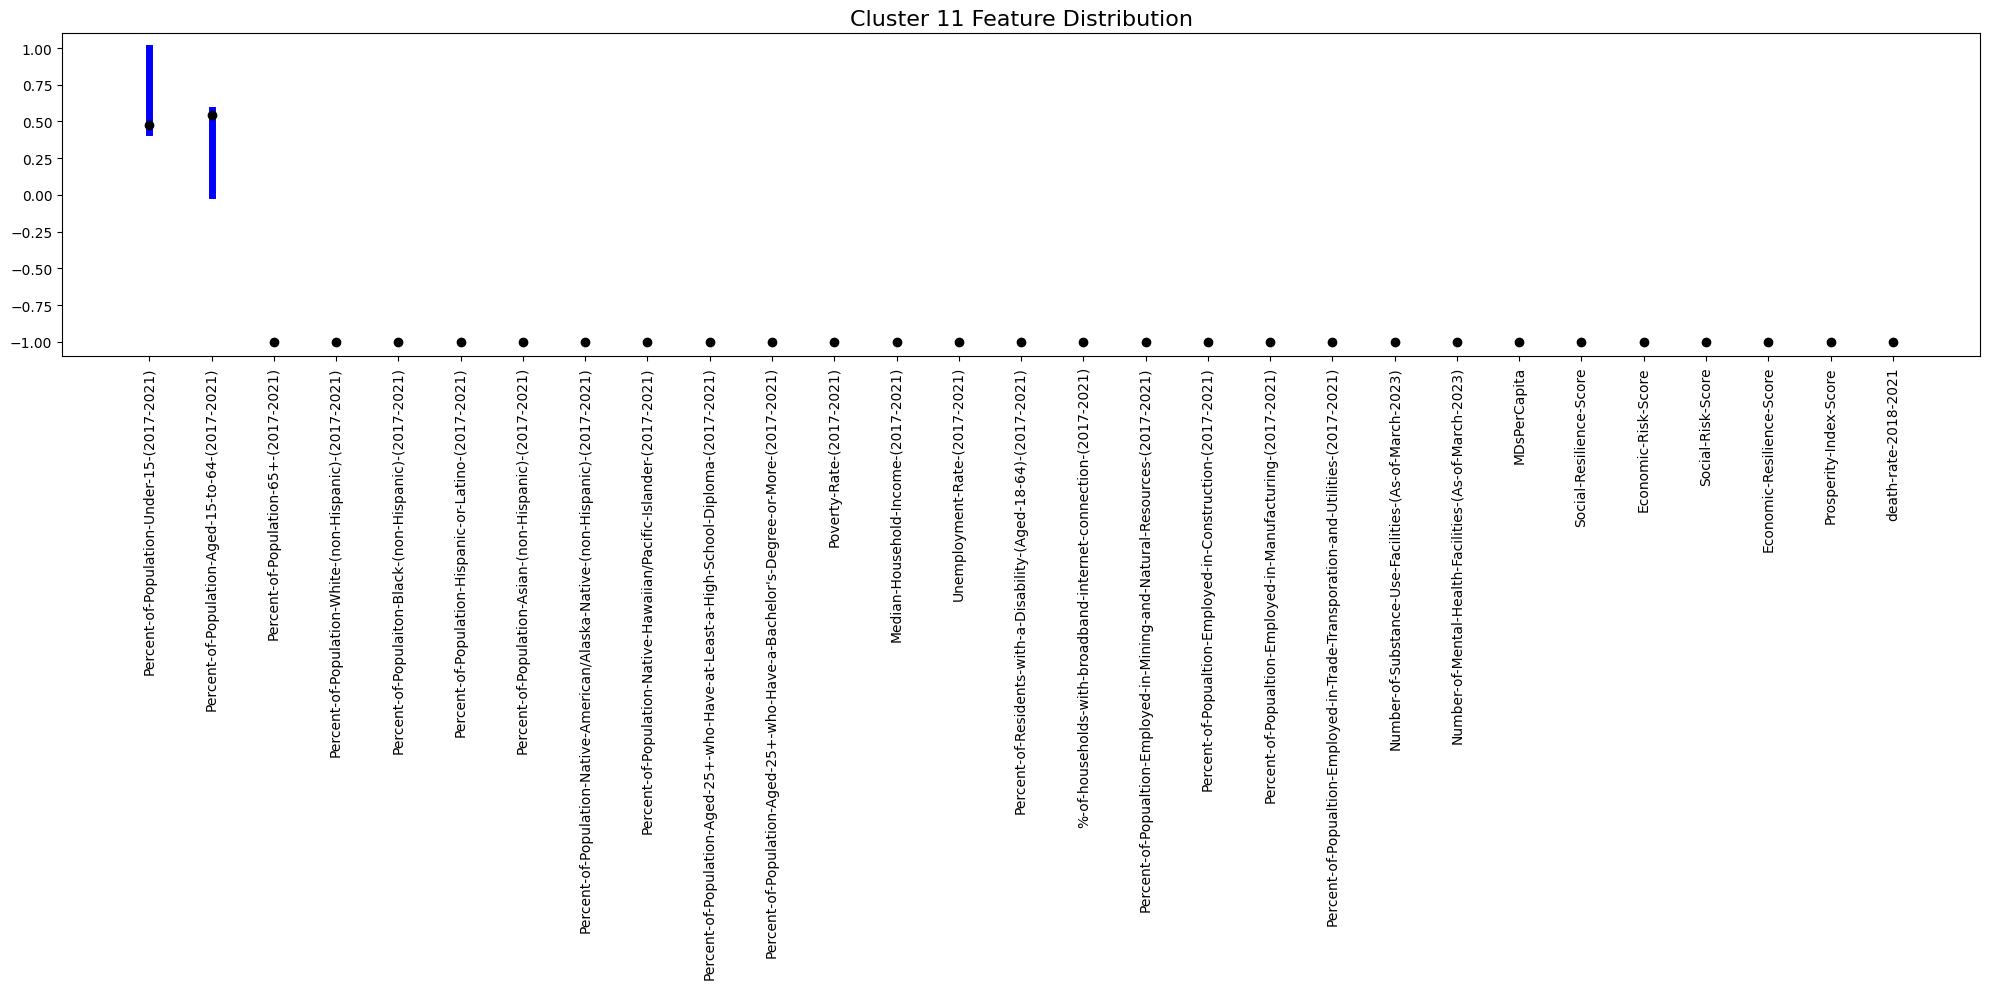

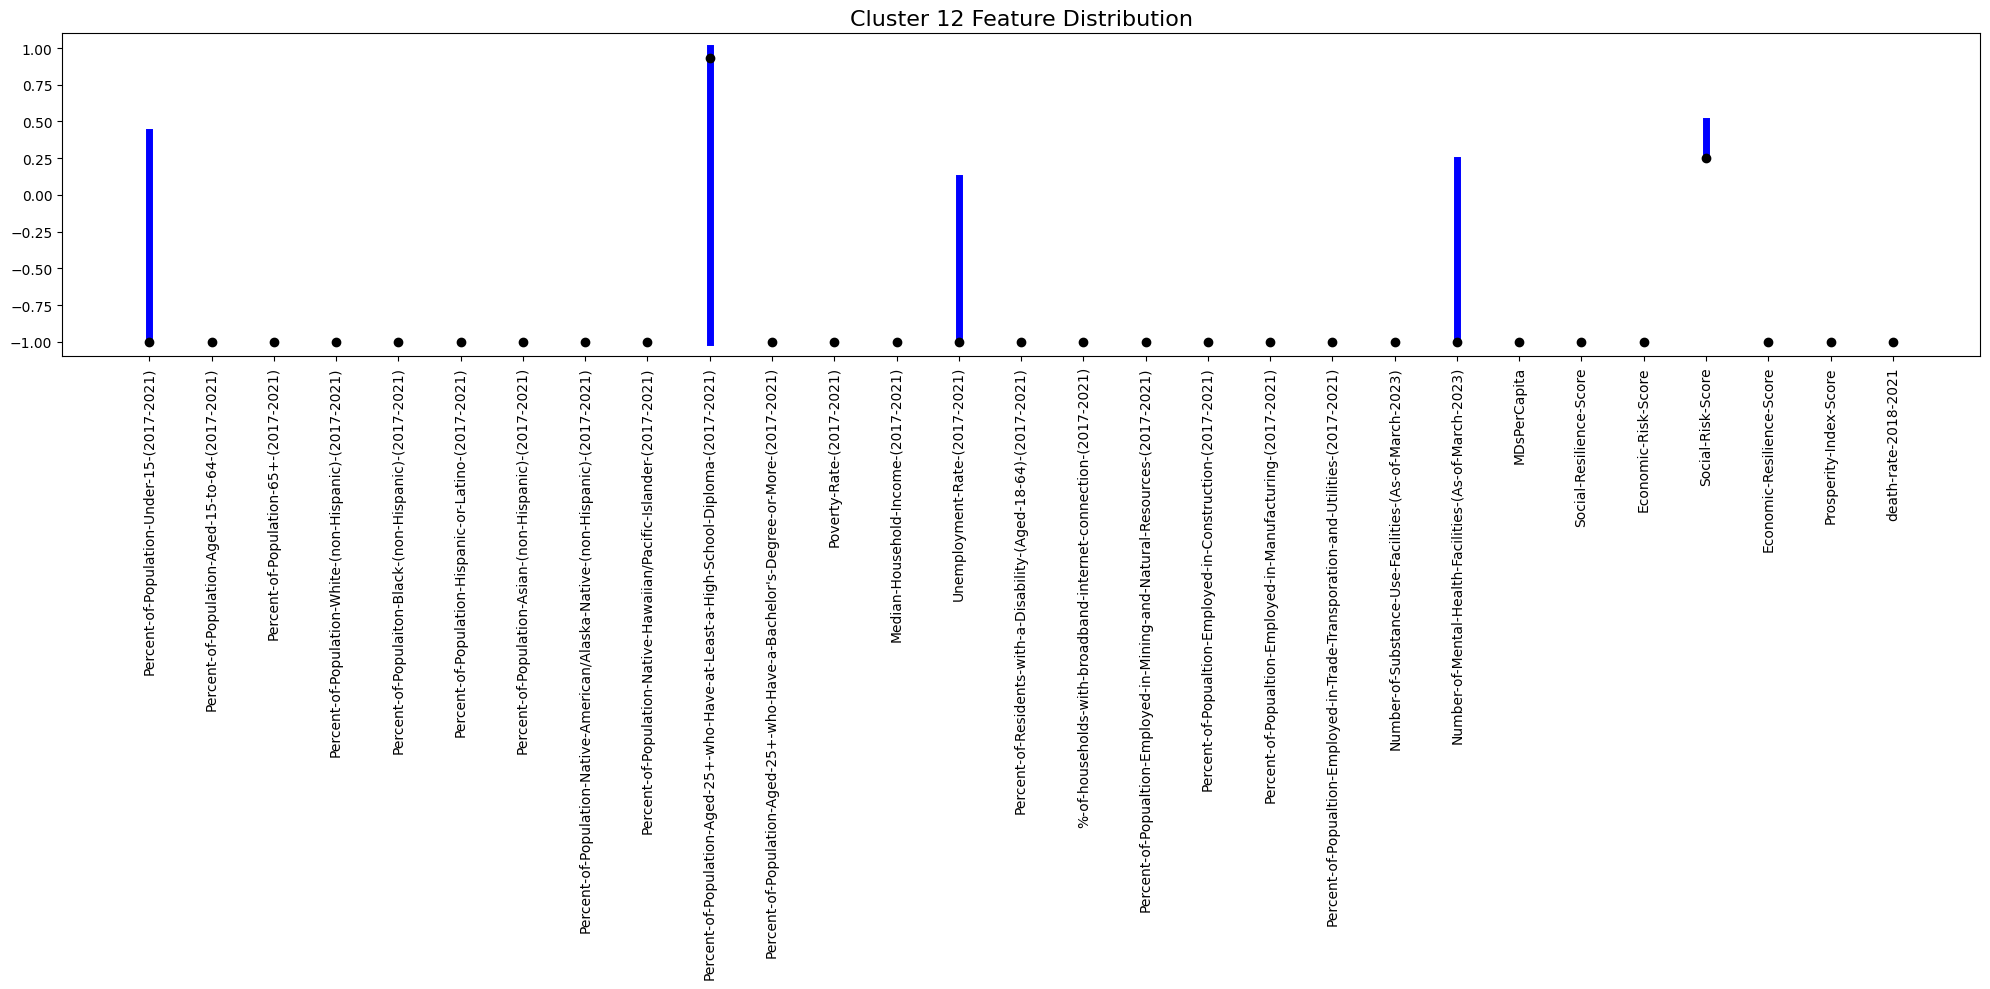

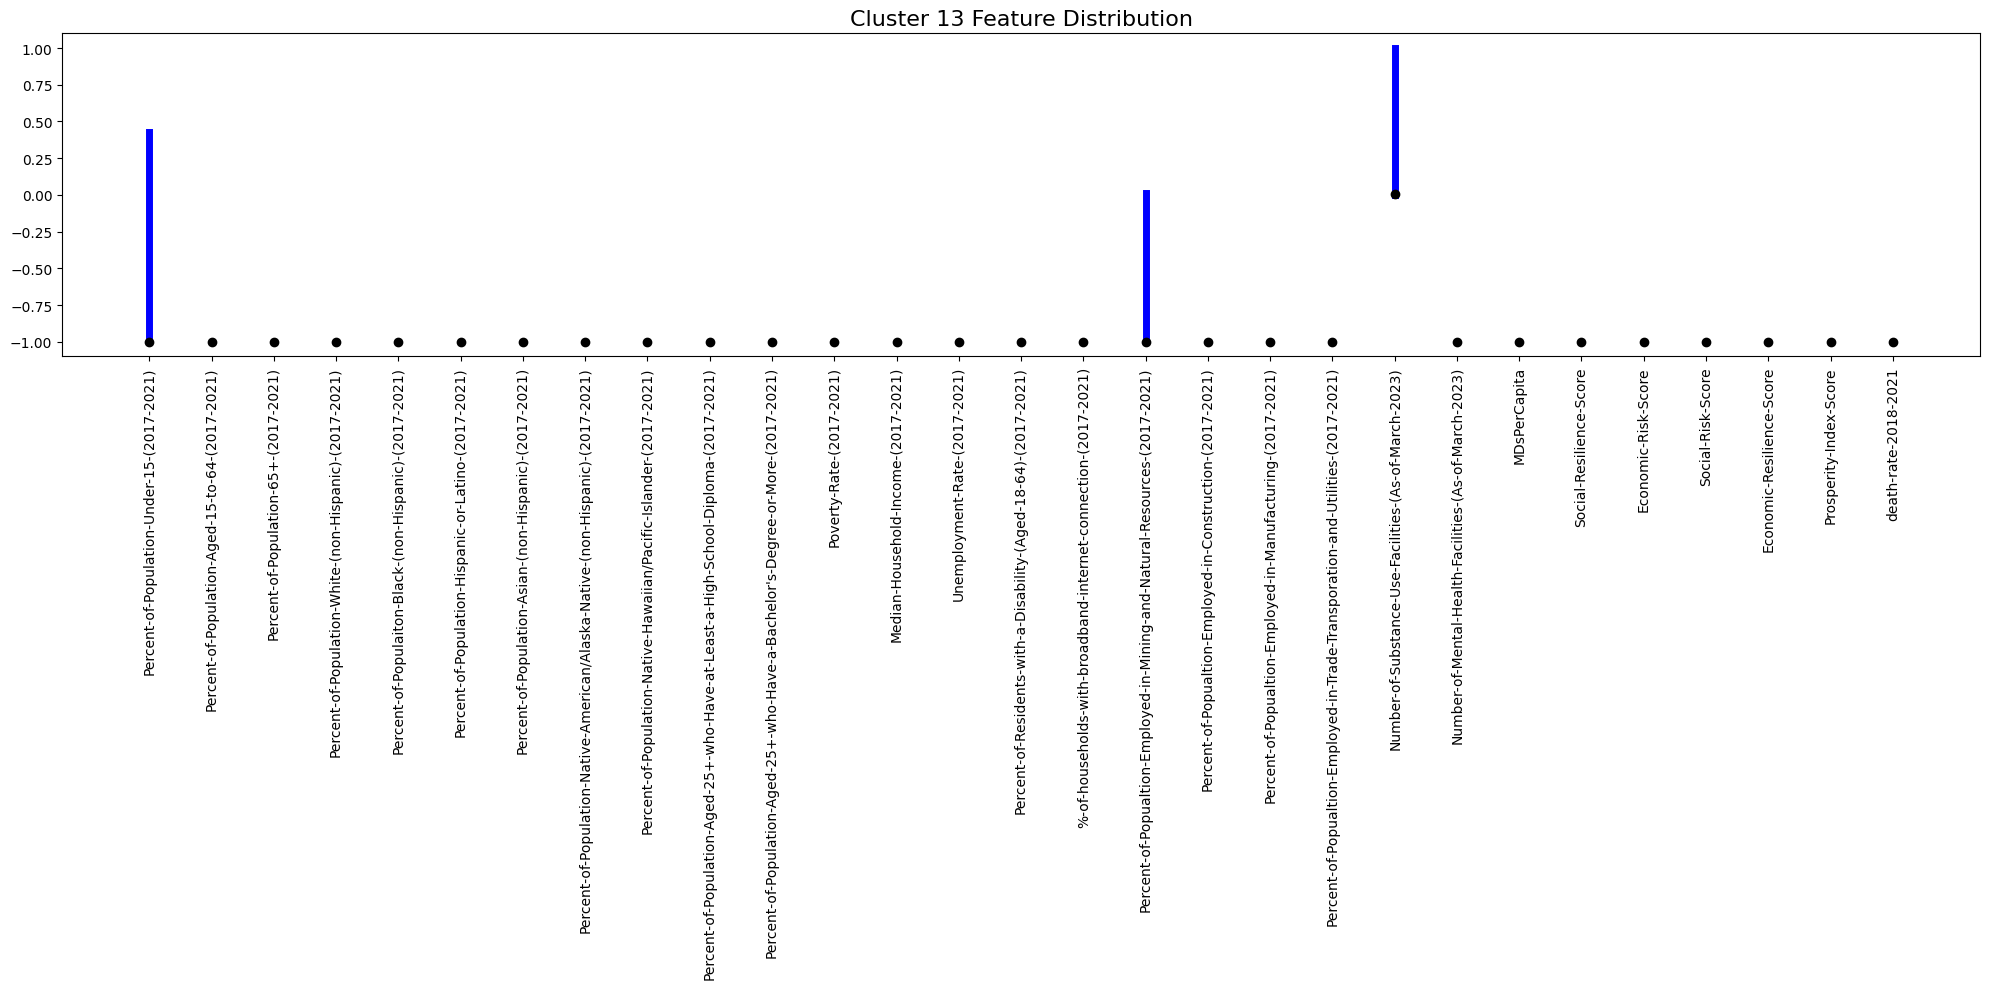

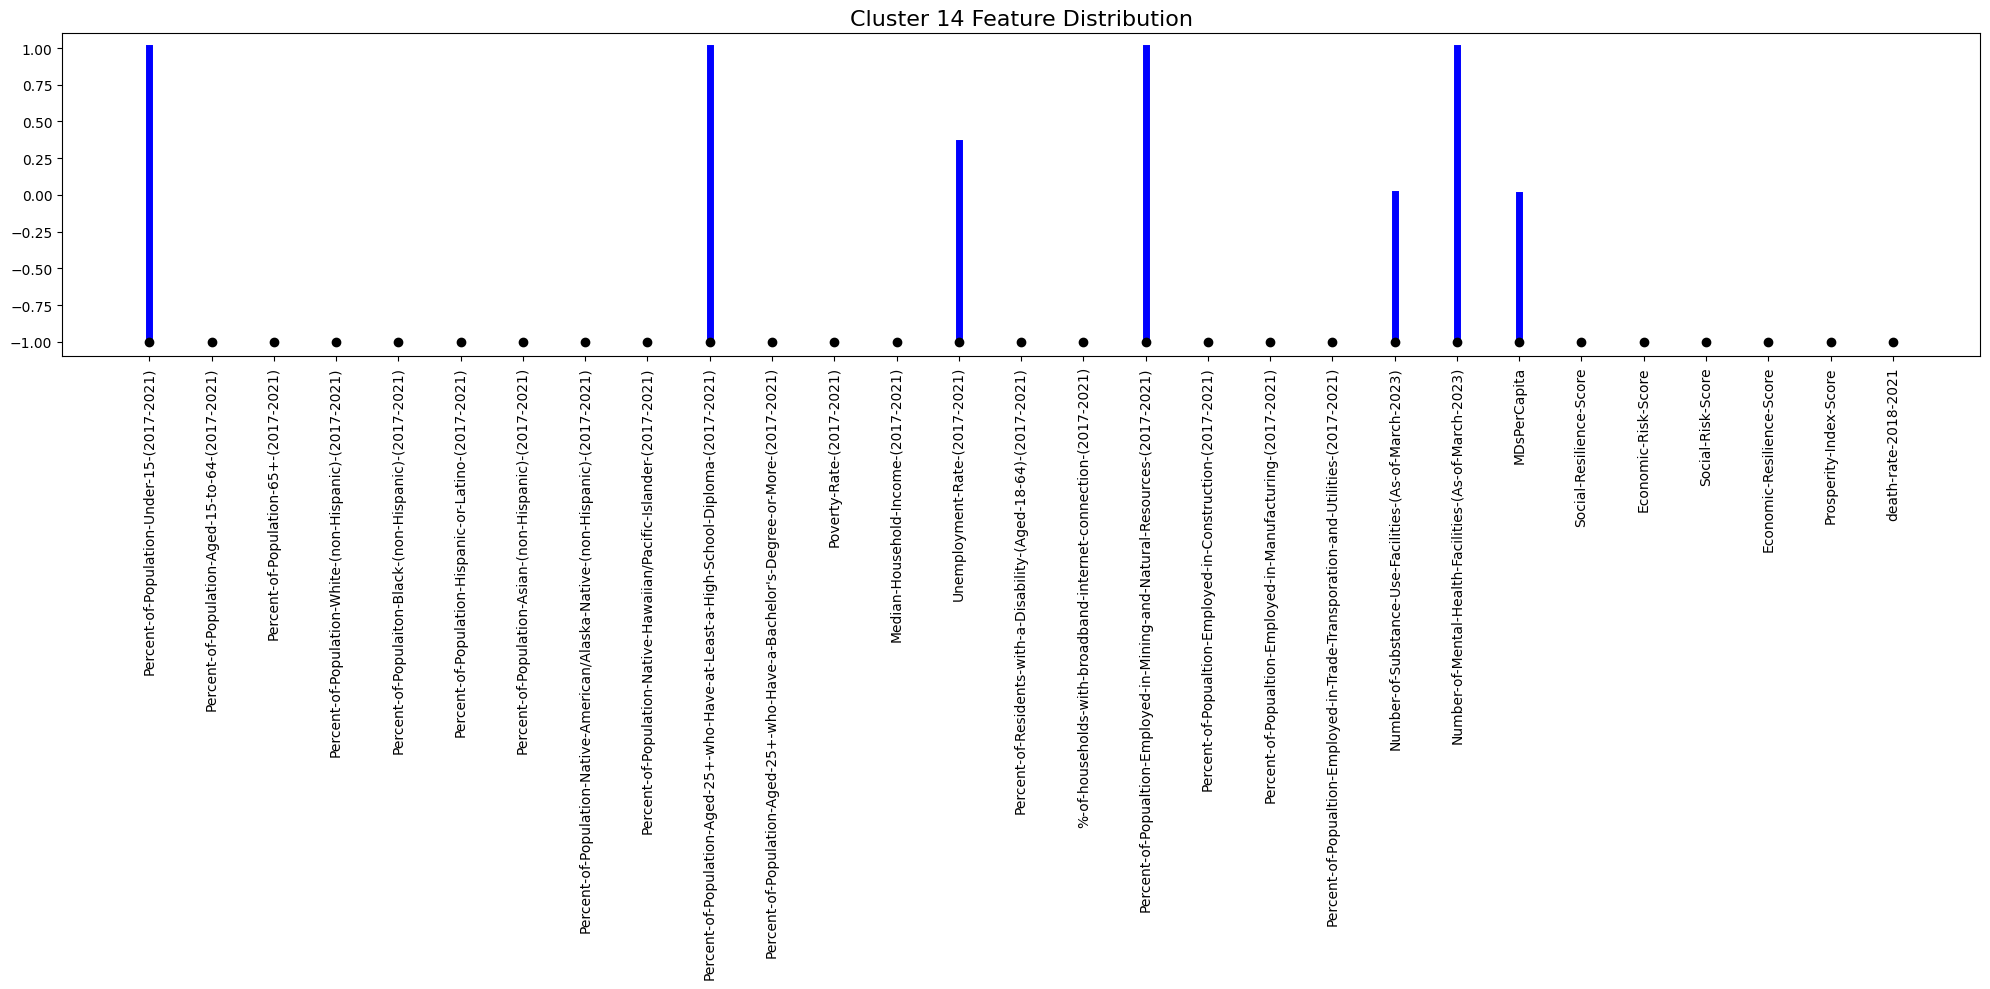

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots for each cluster
for cluster_num in np.unique(cluster_labels):
    # Filter data for the current cluster
    cluster_df = df[df['cluster_label'] == cluster_num][feature_columns]
    cluster_min = cluster_df.min().to_dict()
    cluster_max = cluster_df.max().to_dict()
    cluster_median = cluster_df.median().to_dict()

    plt.figure(figsize=(20, 10))  # Adjust size for better visualization

    # Initialize the plot
    for i, feature in enumerate(feature_columns):
        # Define the min, max, and median for this feature
        min_value = cluster_min[feature]
        max_value = cluster_max[feature]
        median_value = cluster_median[feature]

        # Plot the "blue range" for min-max
        plt.plot([i, i], [min_value, max_value], color='blue', linewidth=5, label='Cluster Min-Max' if i == 0 else "")

        # Plot the median as a horizontal line
        plt.scatter(i, median_value, color='black', zorder=3, label='Cluster Median' if i == 0 else "")

    # Add plot title and adjust aesthetics
    plt.title(f'Cluster {cluster_num} Feature Distribution', fontsize=16)
    plt.xticks(ticks=range(len(feature_columns)), labels=feature_columns, rotation=90, fontsize=10)
    plt.yticks(fontsize=10)

    # Add legend once
    if cluster_num == 0:
        plt.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()


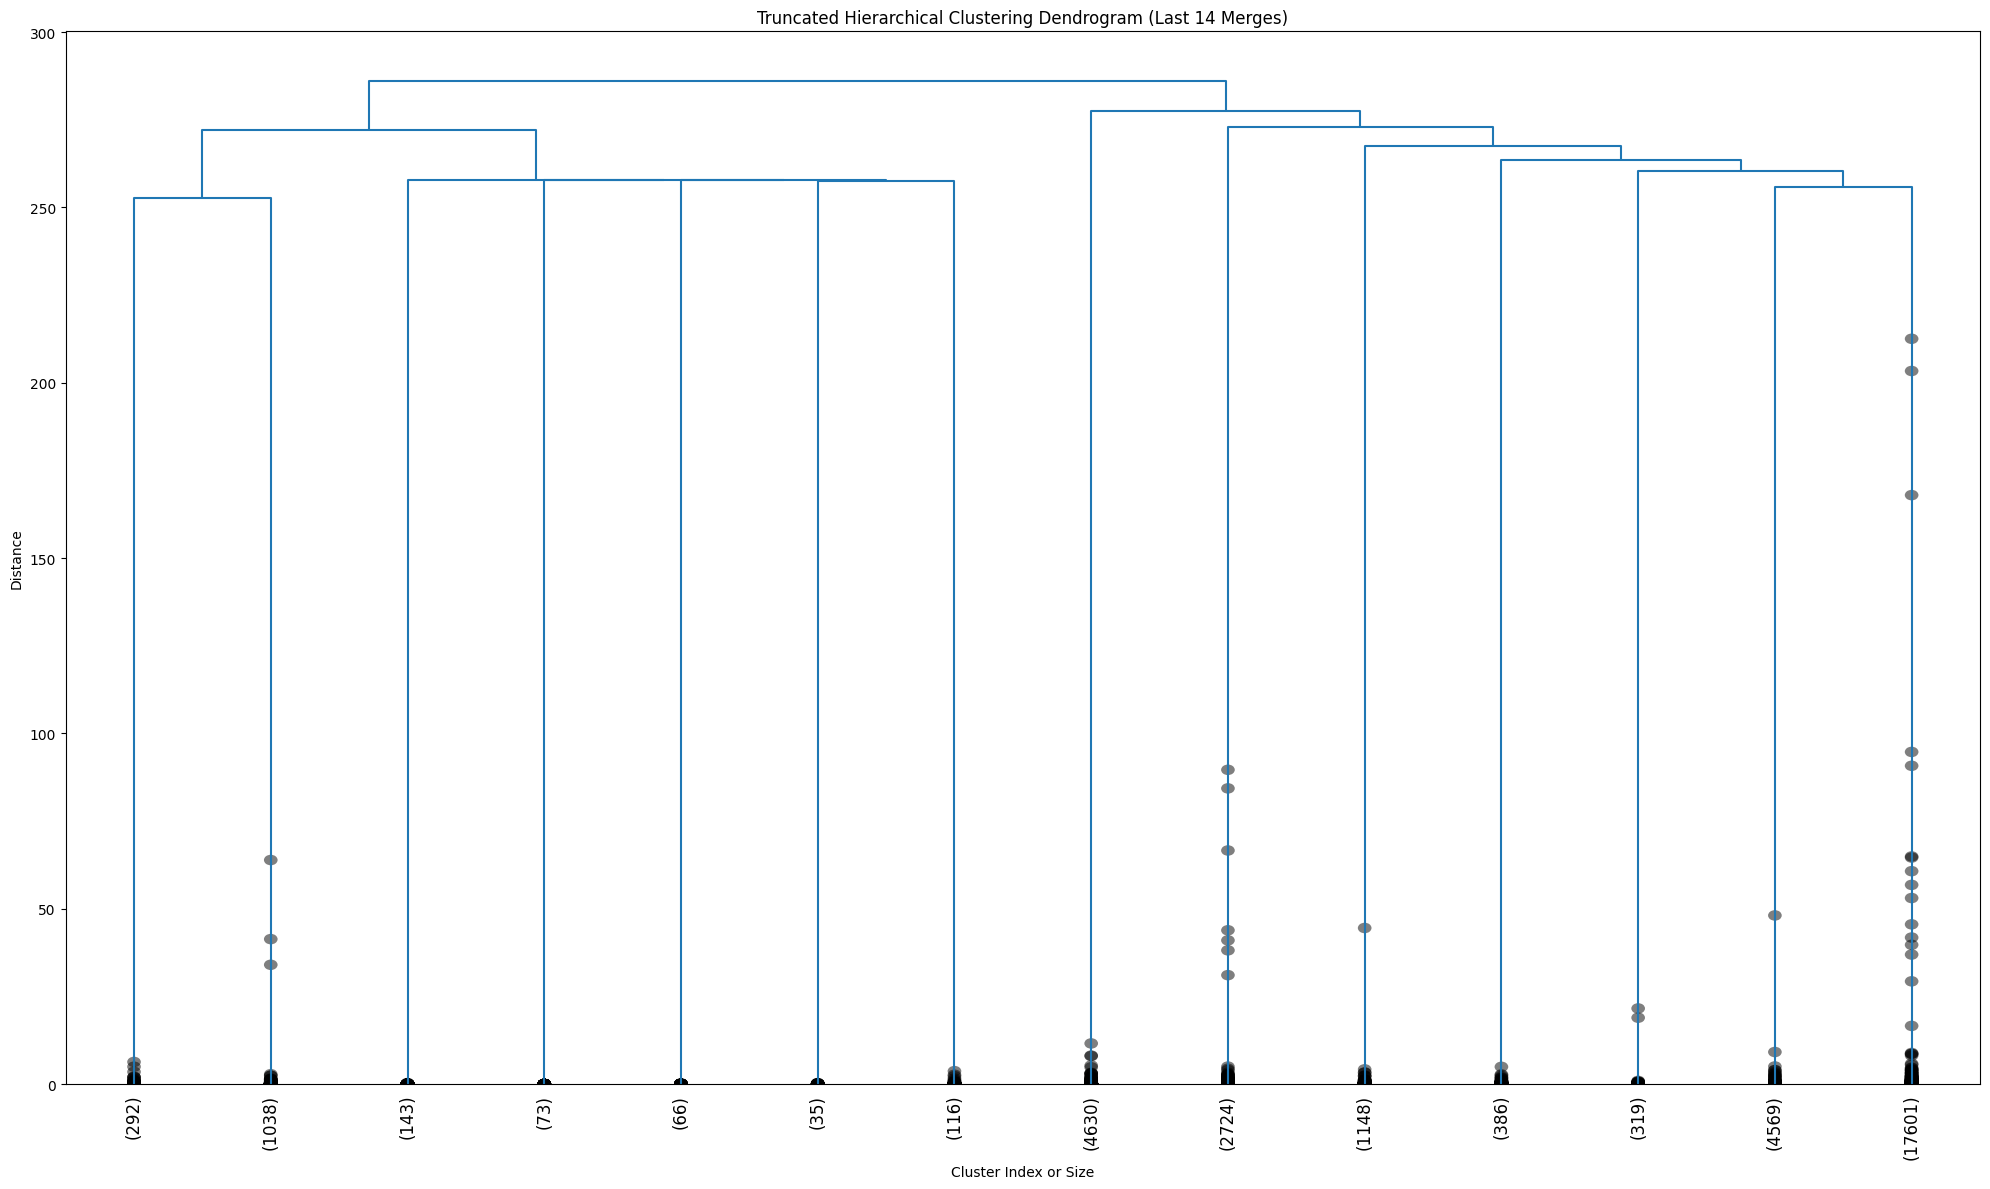

In [ ]:
# Create a truncated dendrogram showing only the n clusters

plt.figure(figsize=(20, 12))
dendrogram = sch.dendrogram(
    linked,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=n_clusters,           # Number of clusters to show
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    color_threshold=None
)

plt.title(f'Truncated Hierarchical Clustering Dendrogram (Last {n_clusters} Merges)')
plt.xlabel('Cluster Index or Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


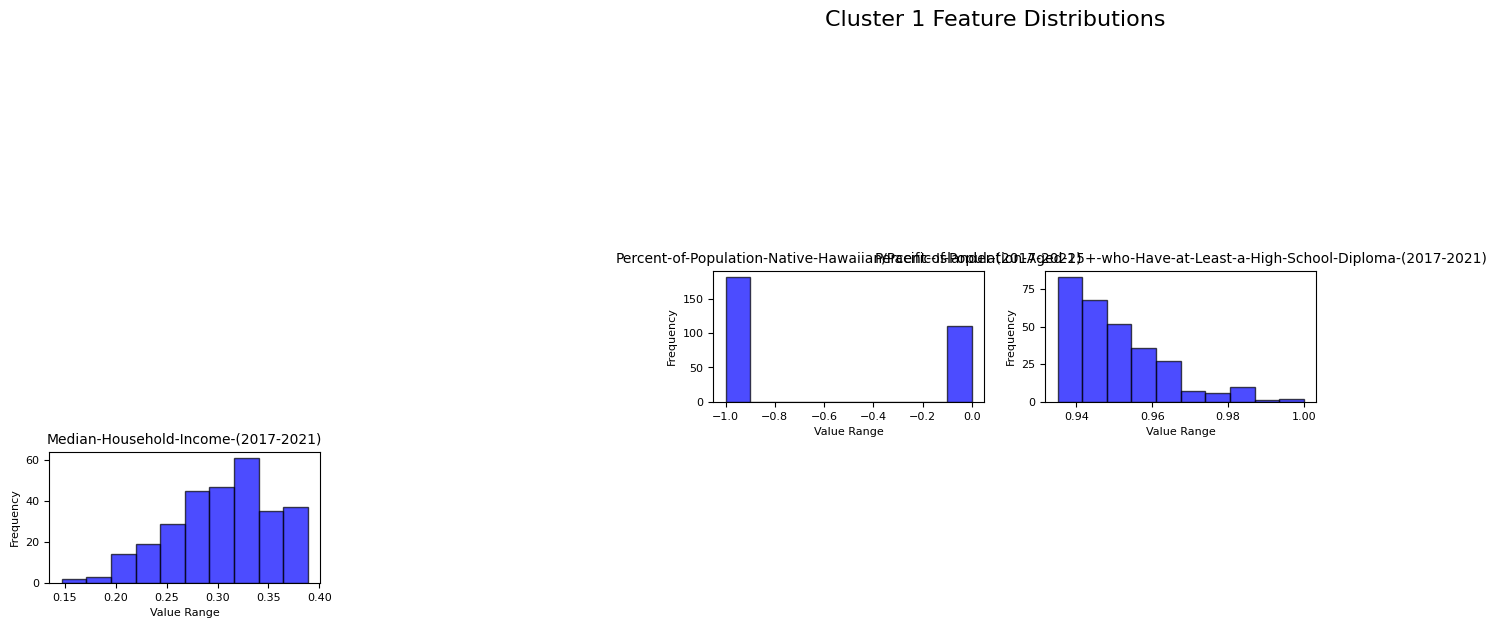

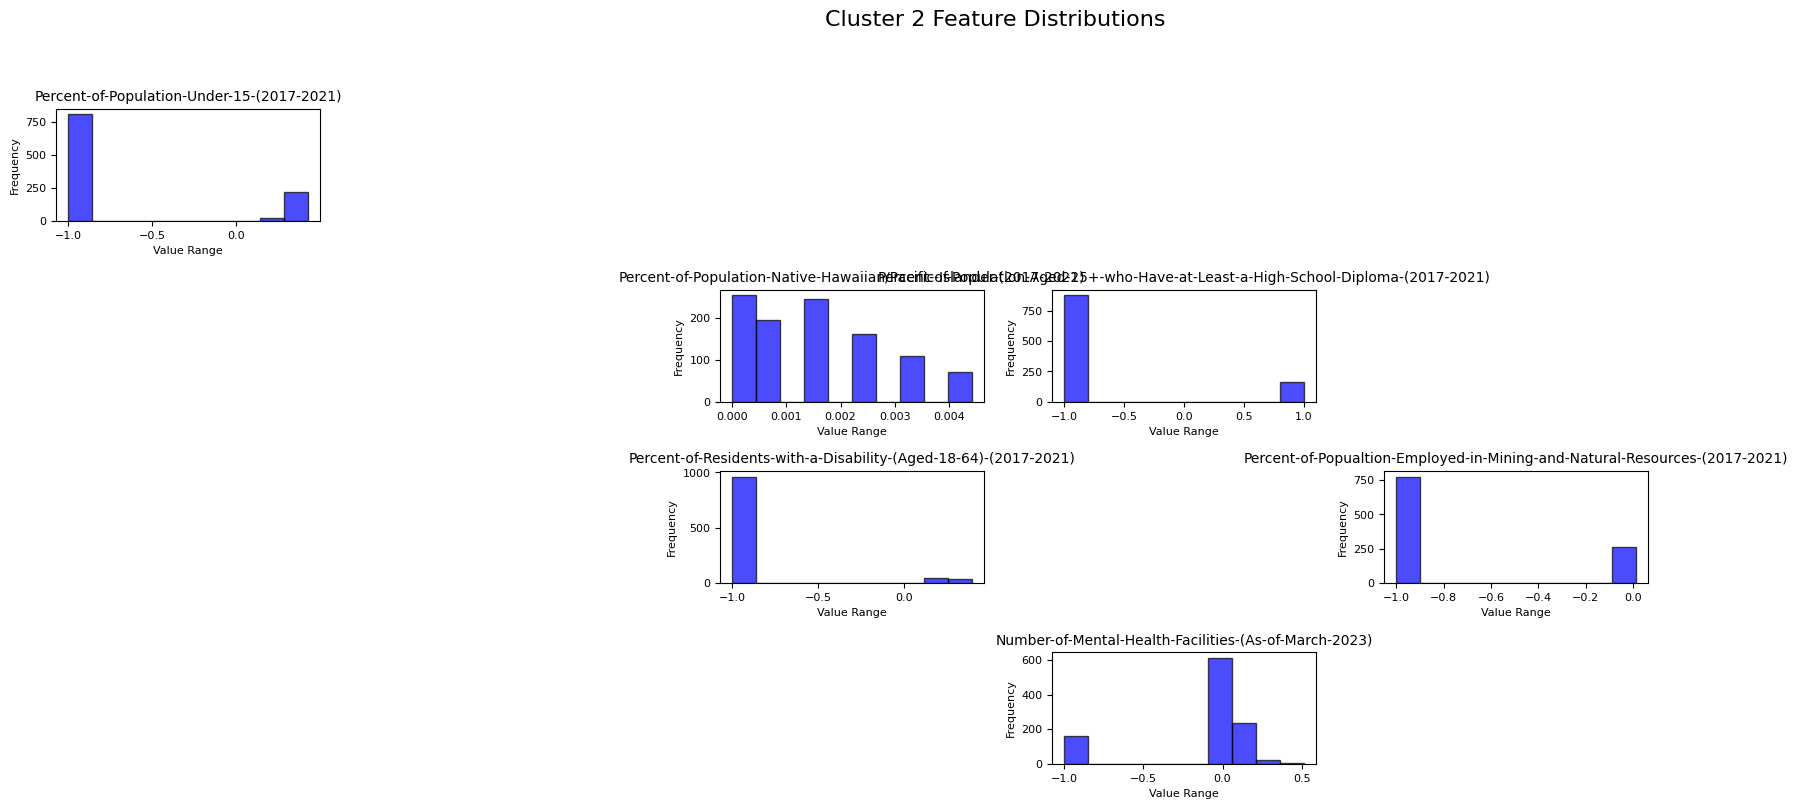

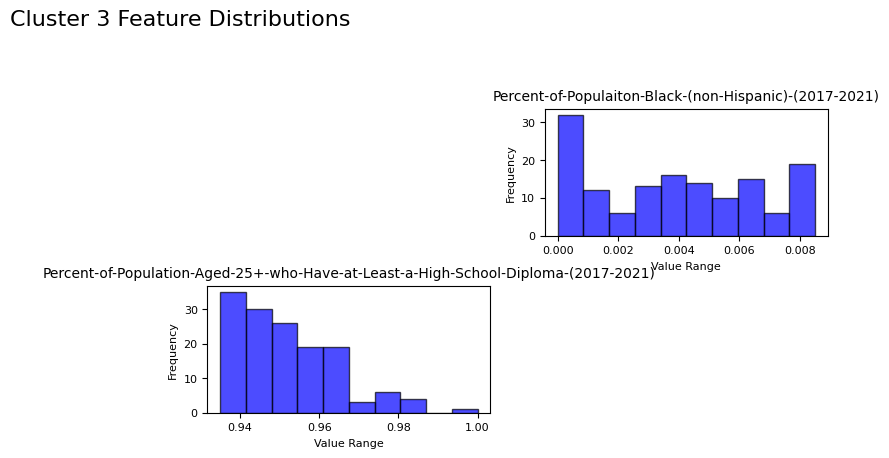

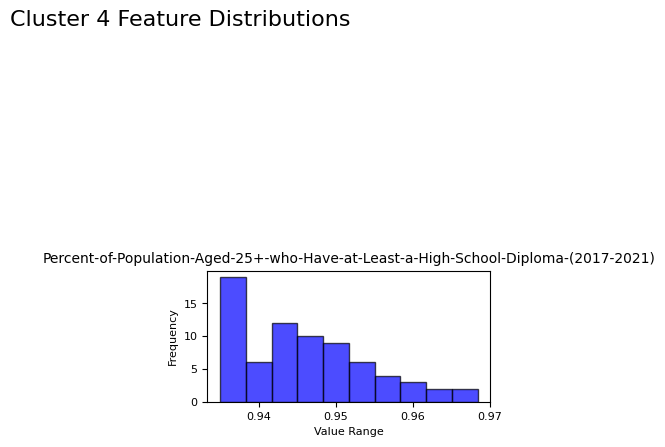

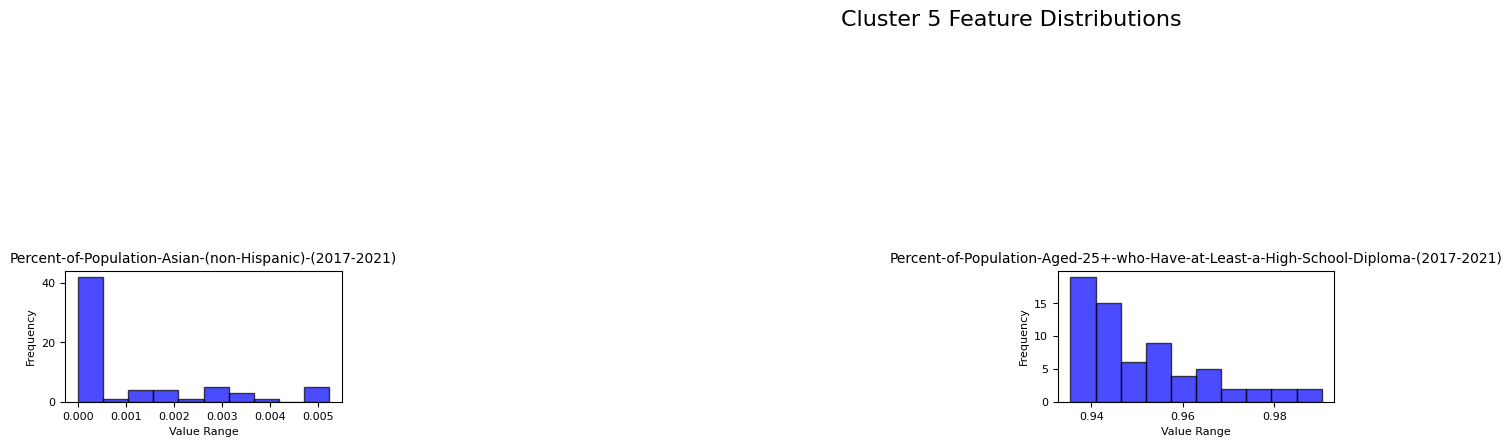

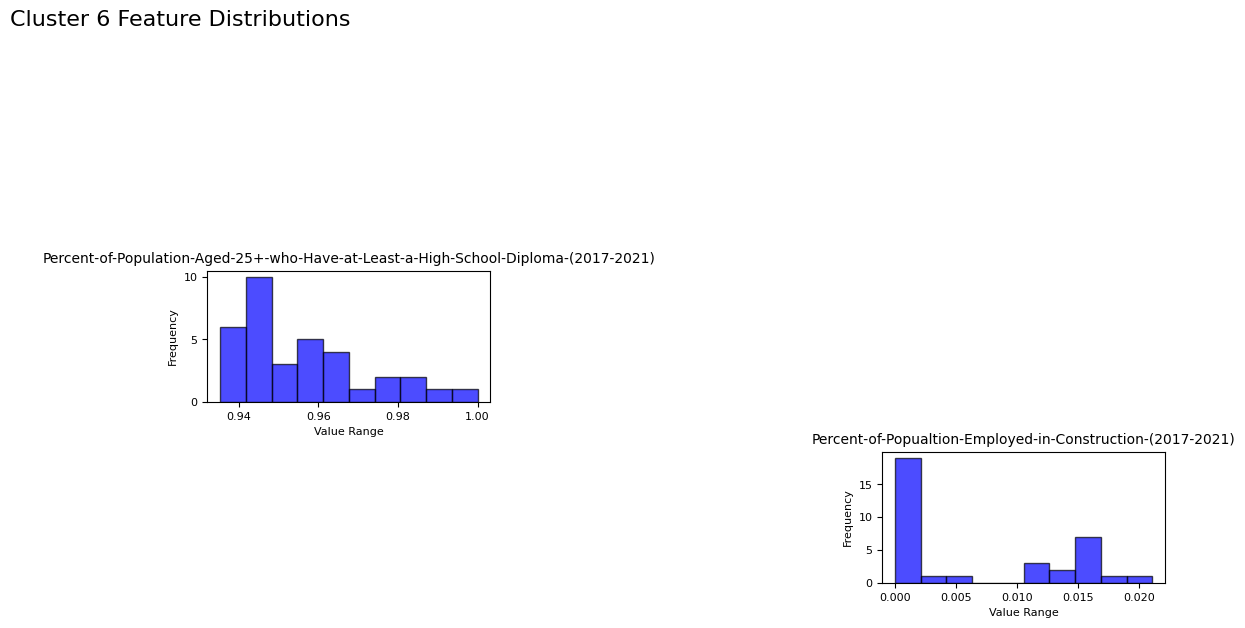

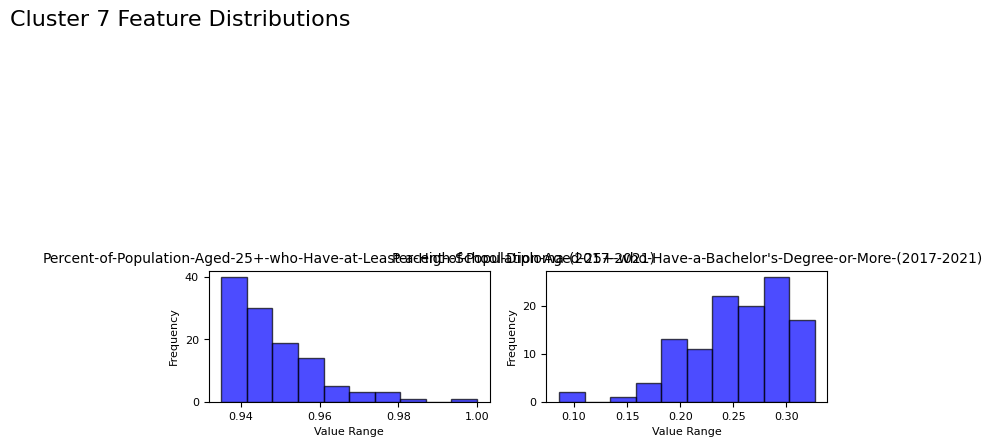

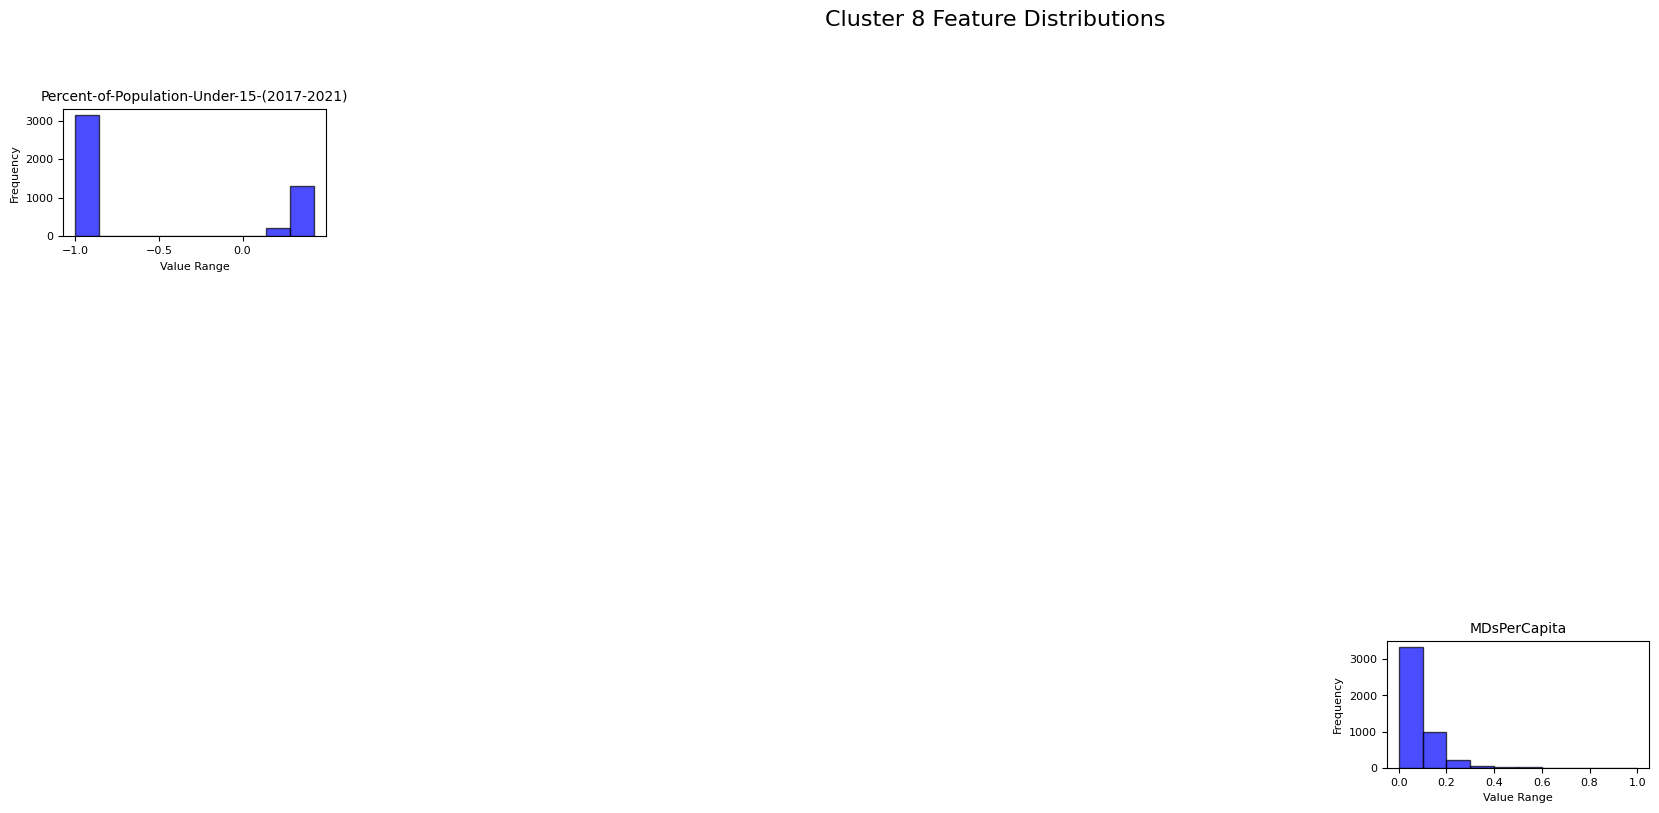

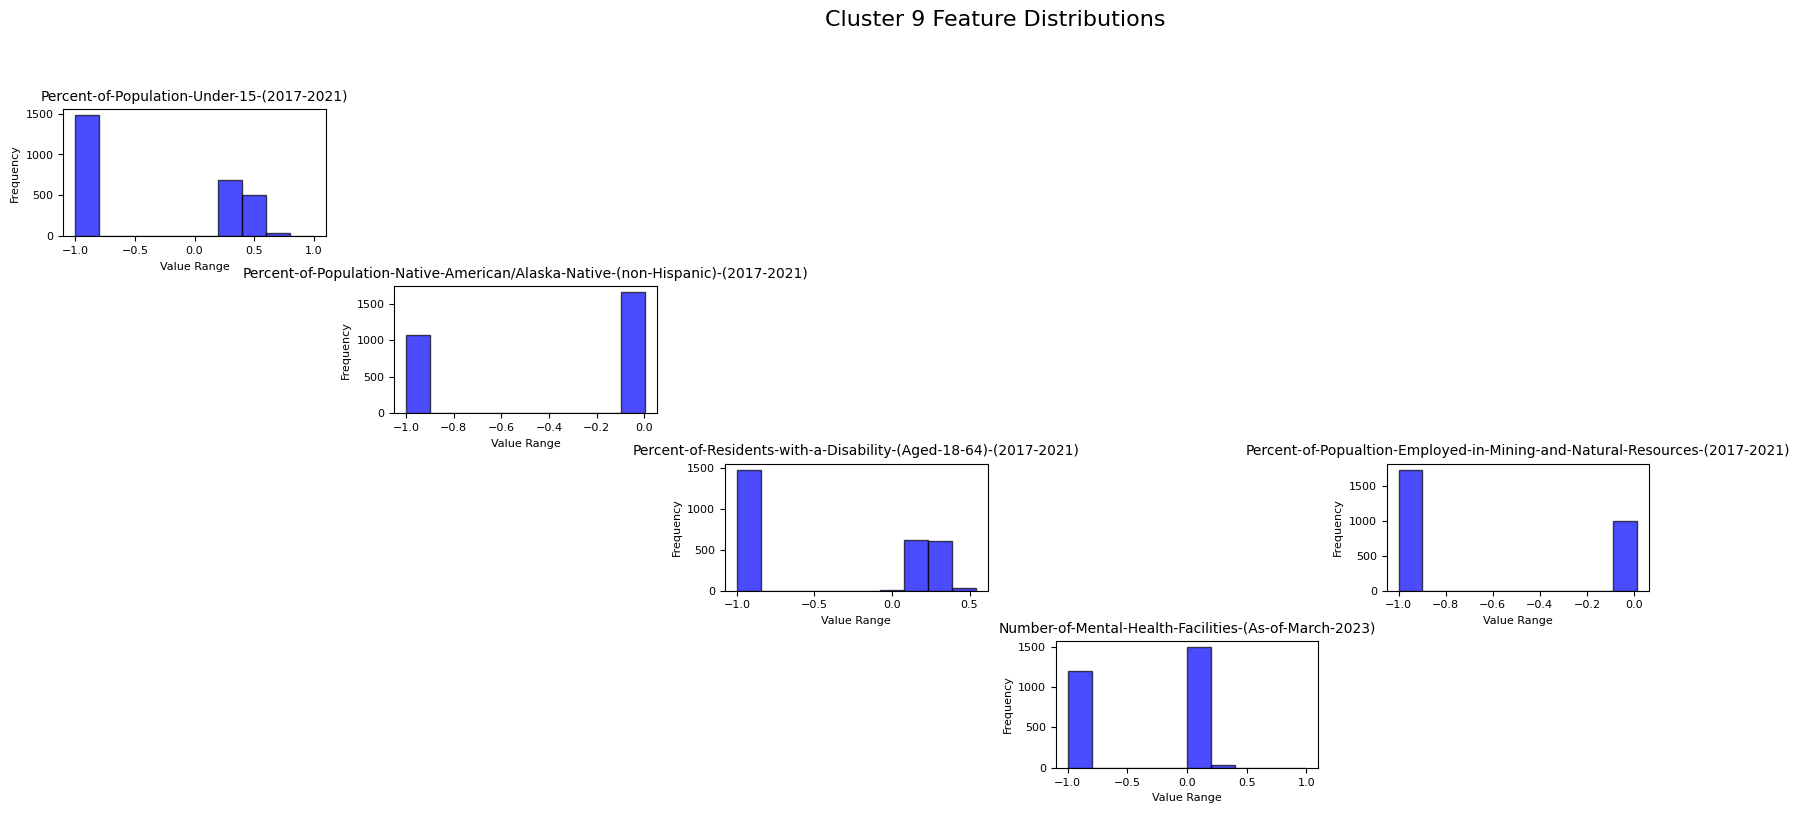

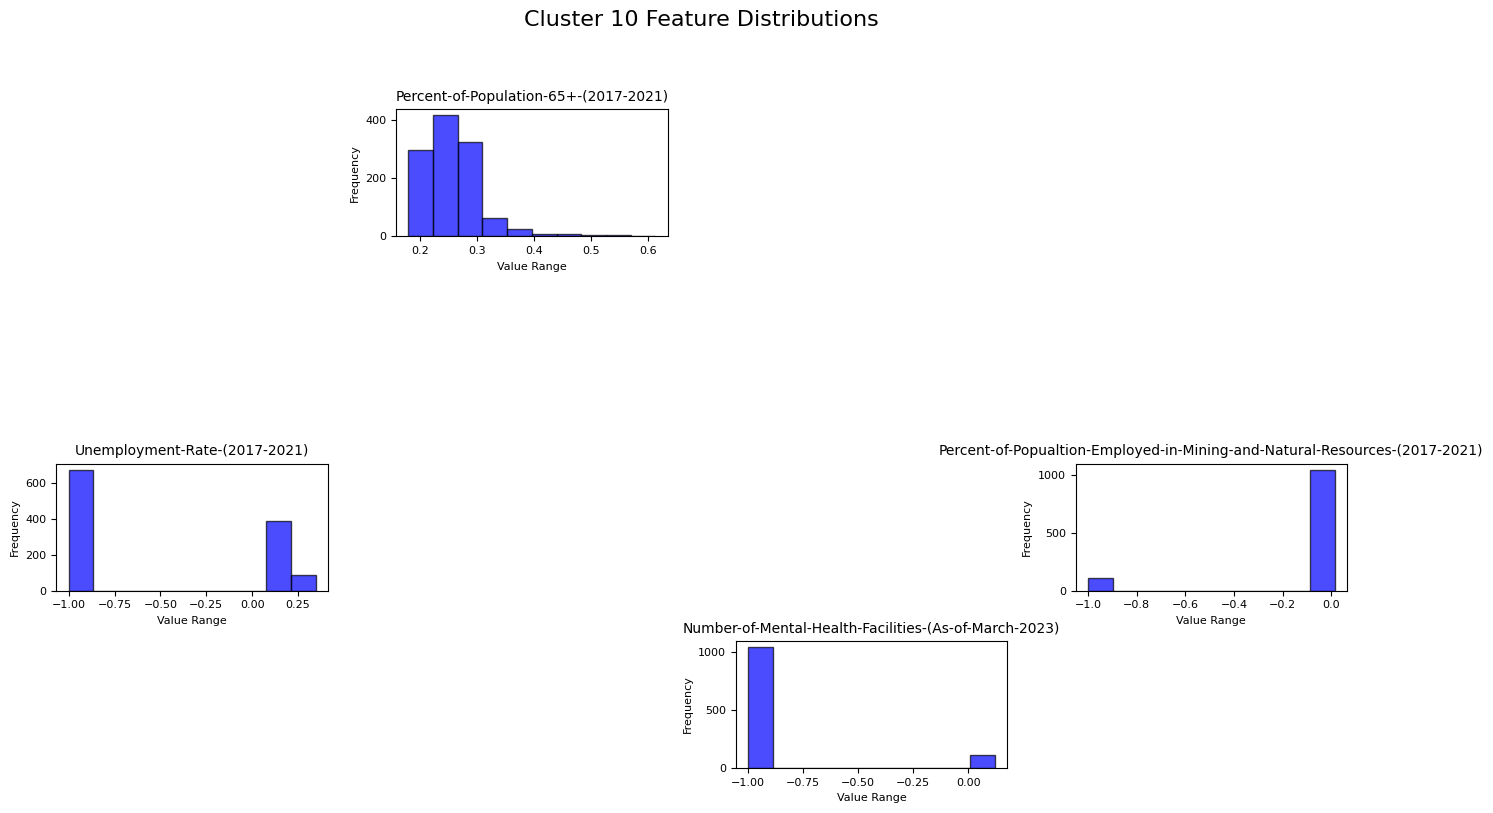

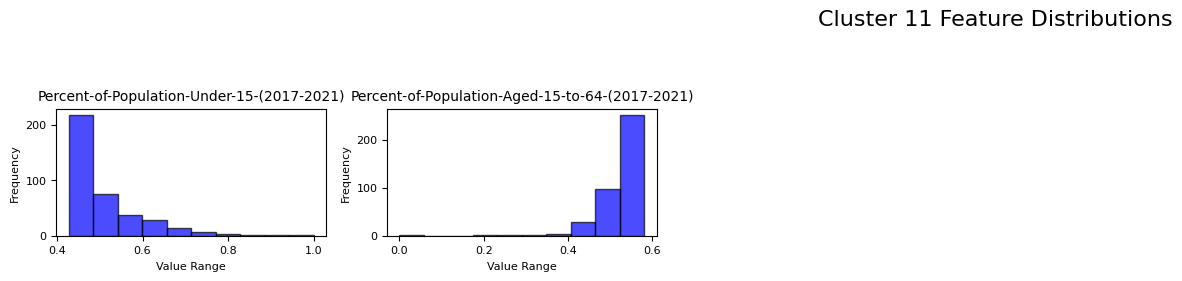

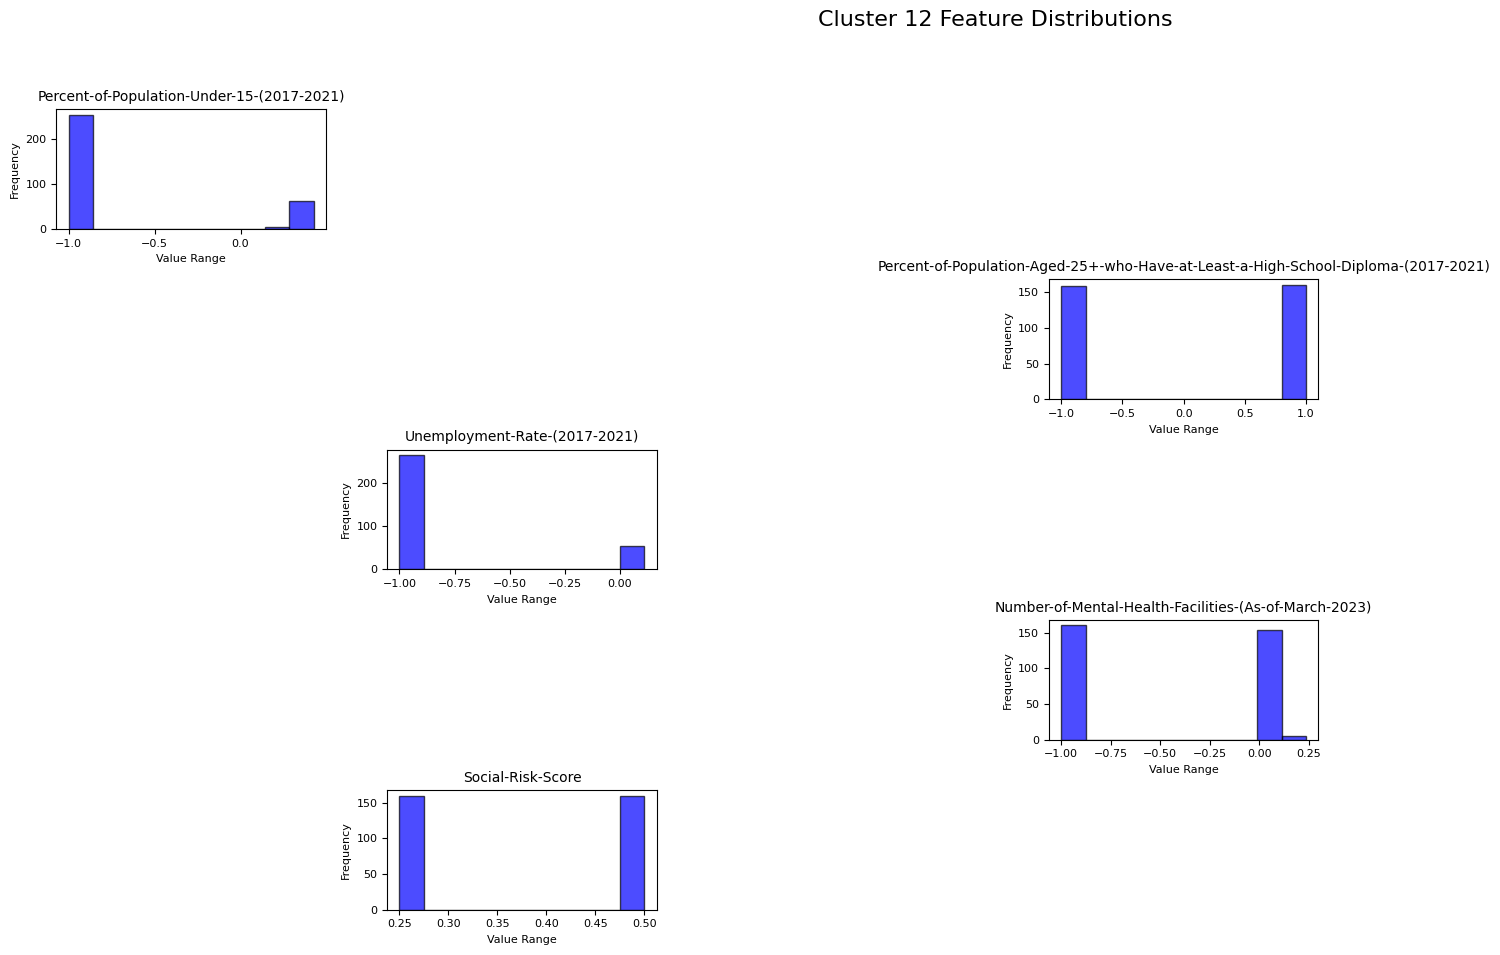

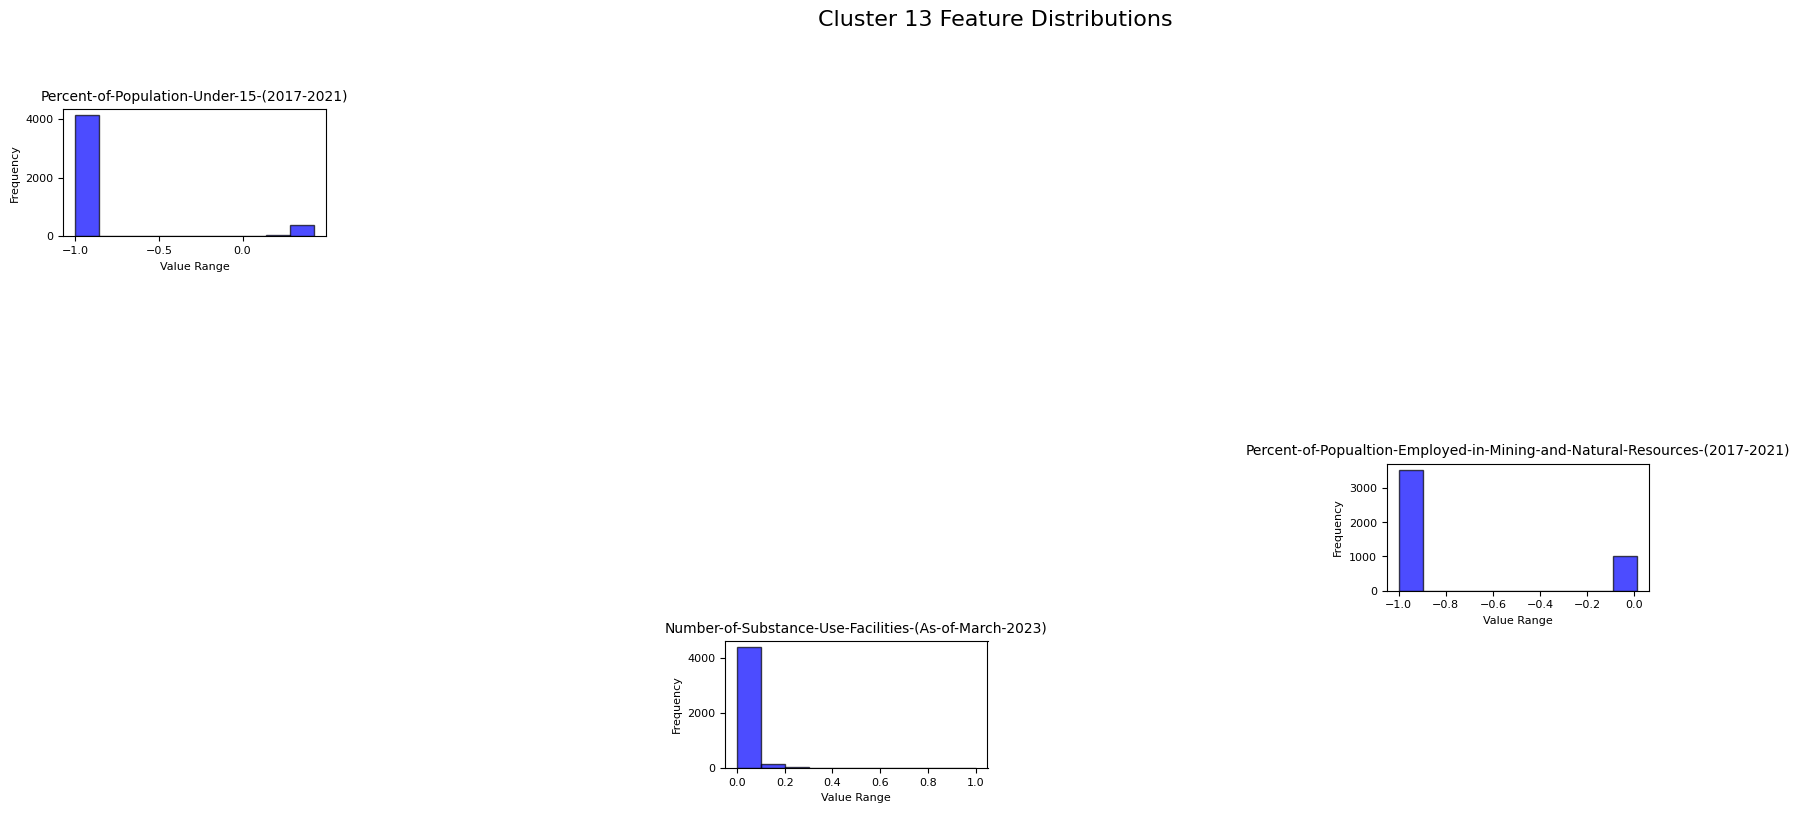

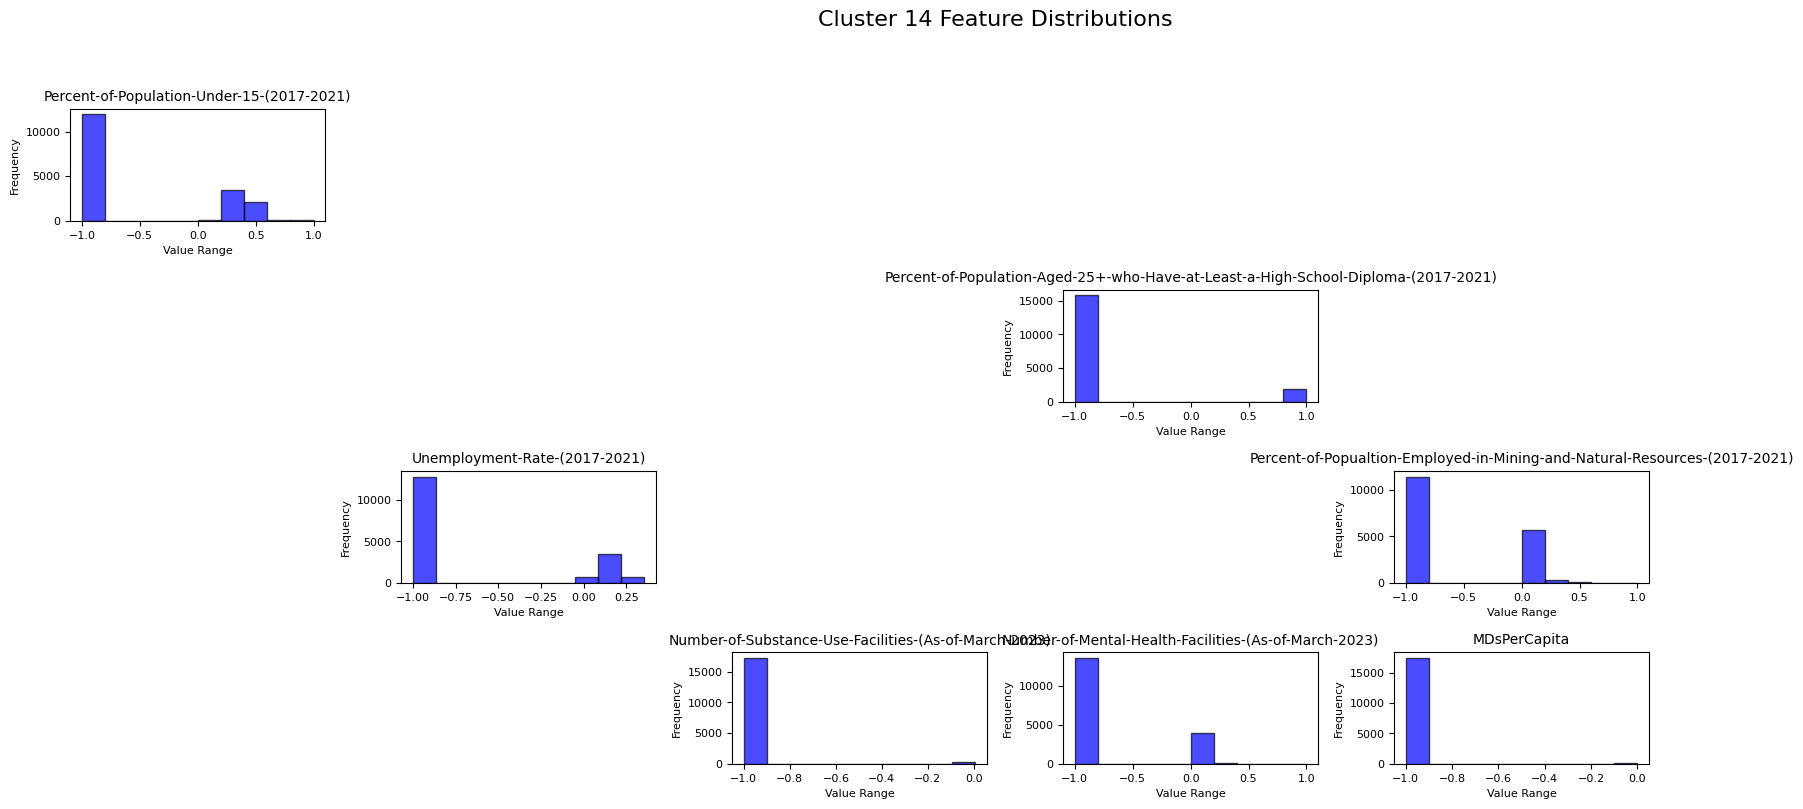

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms for each feature in each cluster with non-zero range
for cluster_num in np.unique(cluster_labels):
    # Filter data for the current cluster
    cluster_df = df[df['cluster_label'] == cluster_num][feature_columns]

    plt.figure(figsize=(20, 10))  # Adjust size for better visualization
    plt.suptitle(f'Cluster {cluster_num} Feature Distributions', fontsize=16)

    for i, feature in enumerate(feature_columns):
        min_value = cluster_df[feature].min()
        max_value = cluster_df[feature].max()

        # Skip features where the range is zero
        if min_value == max_value:
            continue

        # Compute the frequency distribution
        plt.subplot(5, 6, i + 1)  # Create a grid of subplots (adjust grid size if necessary)
        plt.hist(
            cluster_df[feature], bins=10, color='blue', alpha=0.7, edgecolor='black'
        )

        # Add labels and title
        plt.title(feature, fontsize=10)
        plt.xlabel('Value Range', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


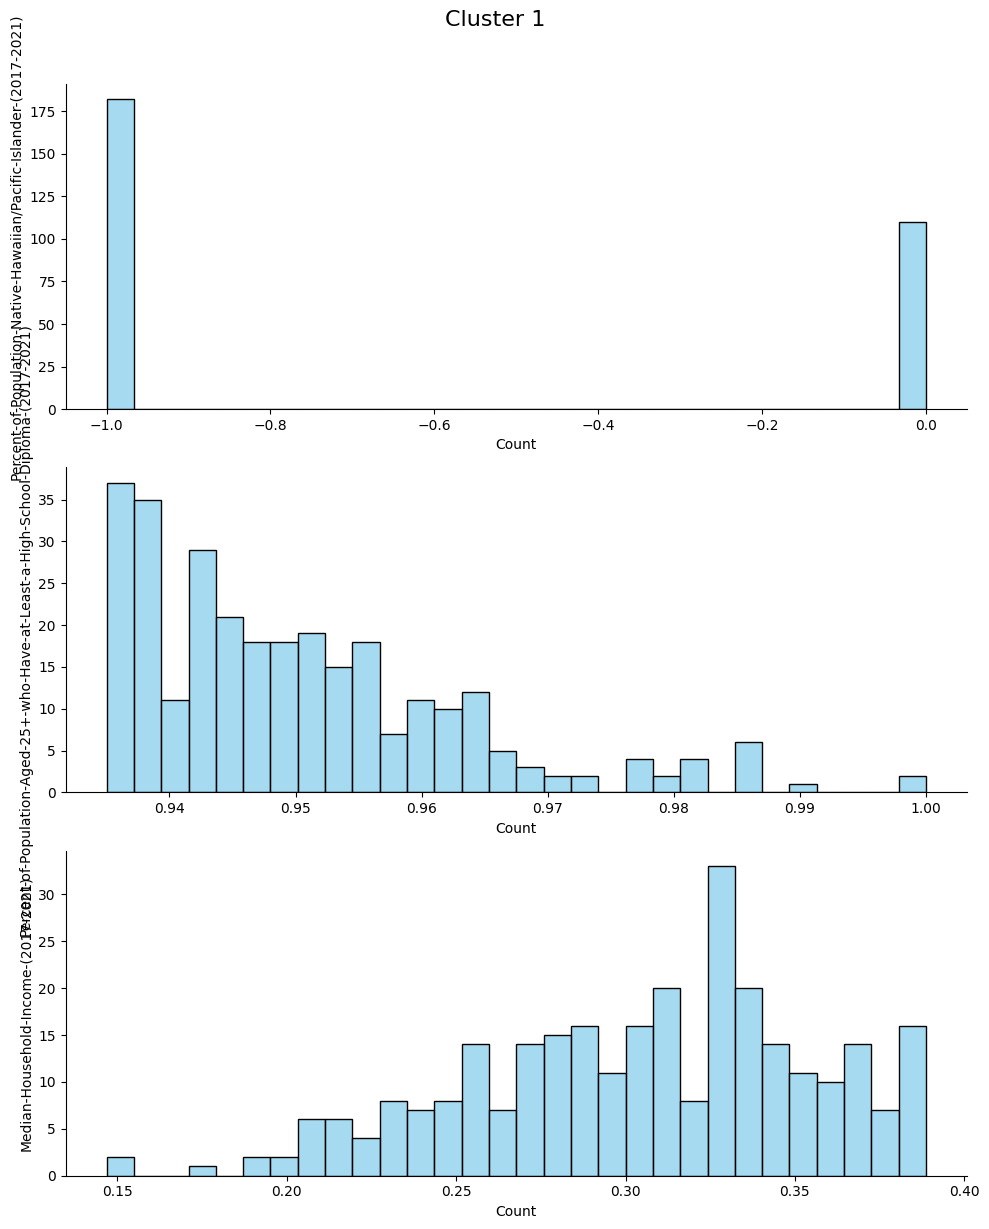

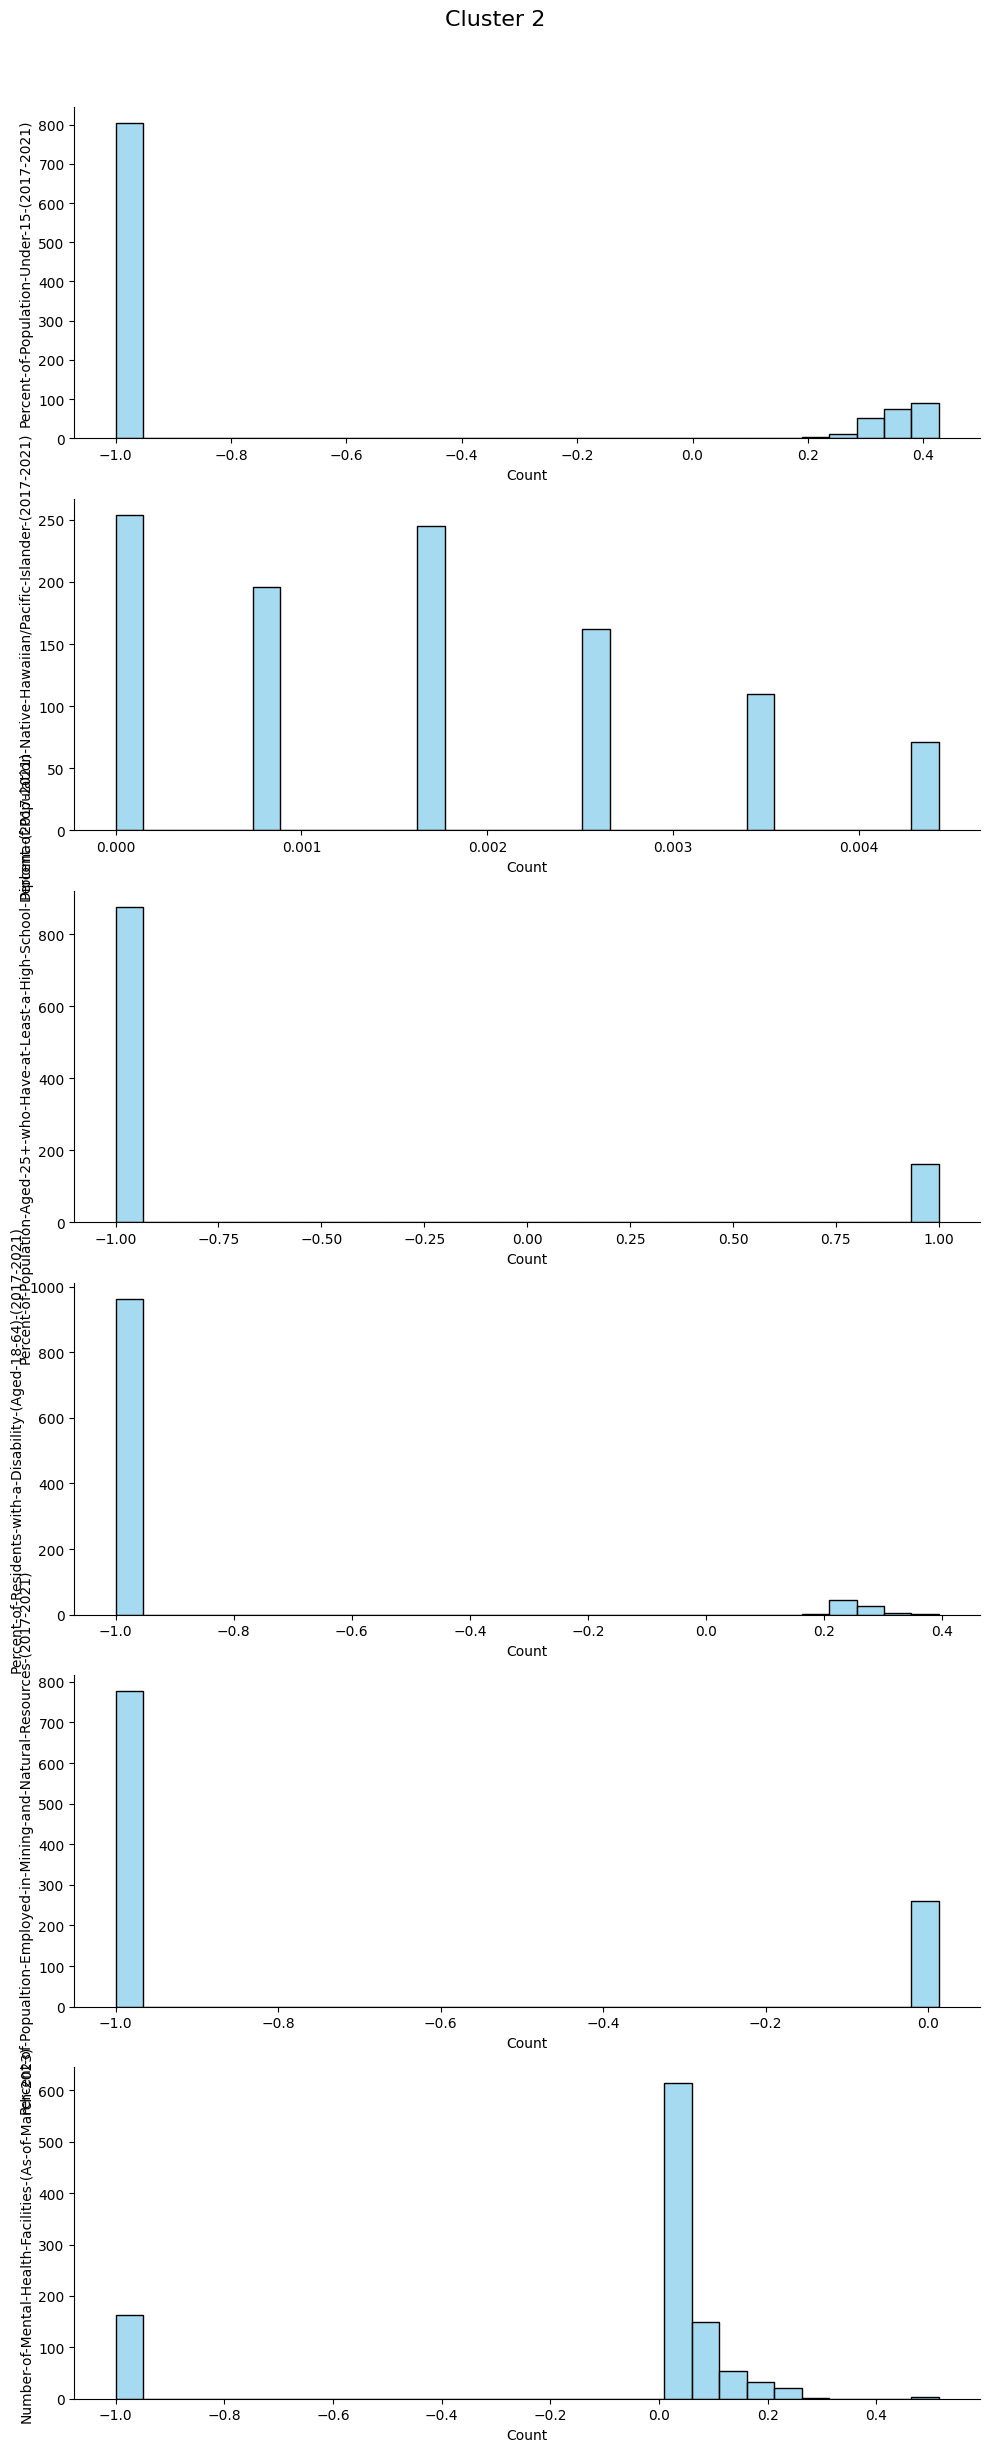

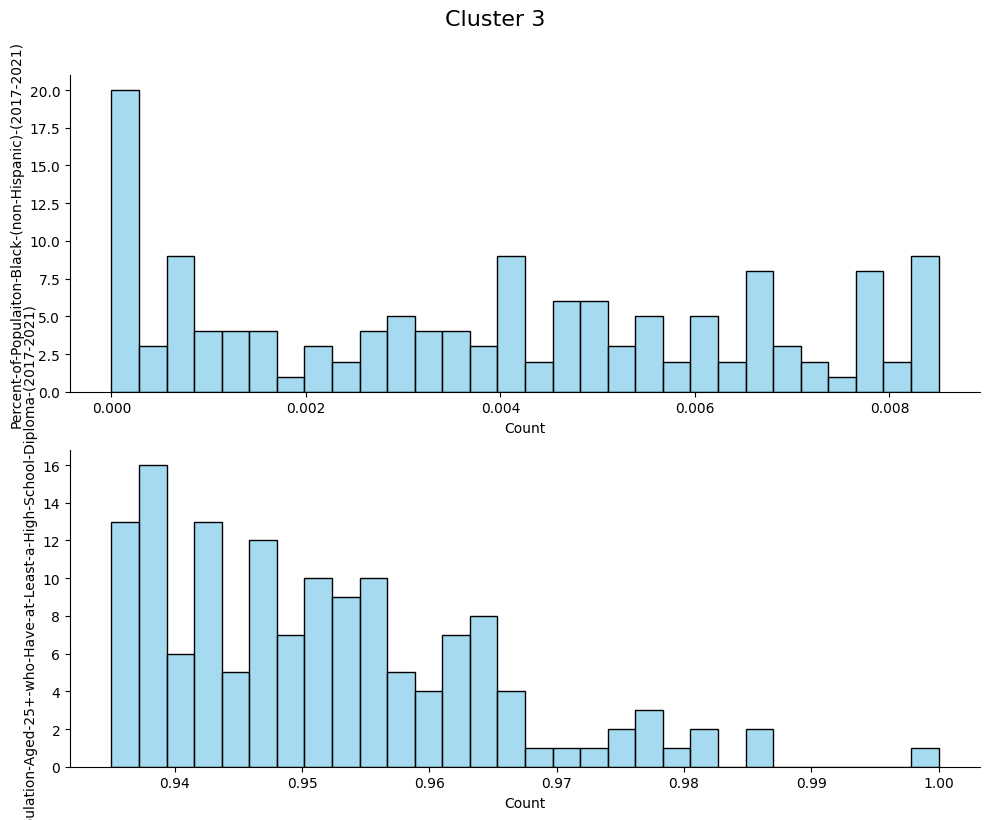

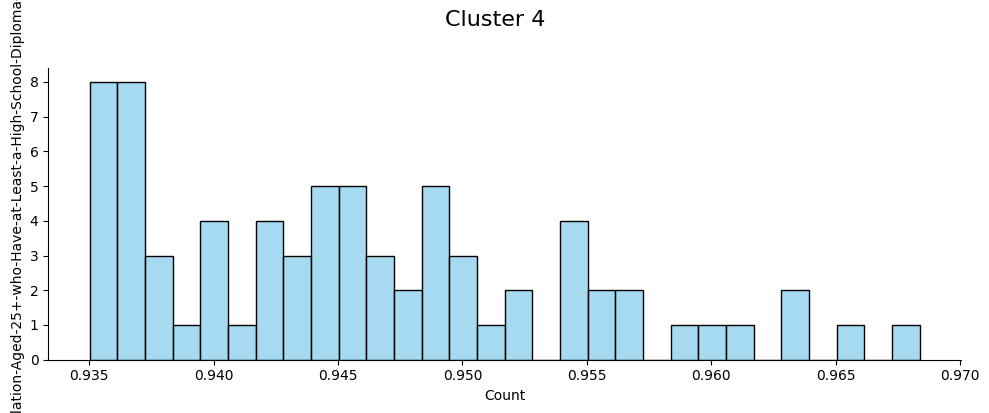

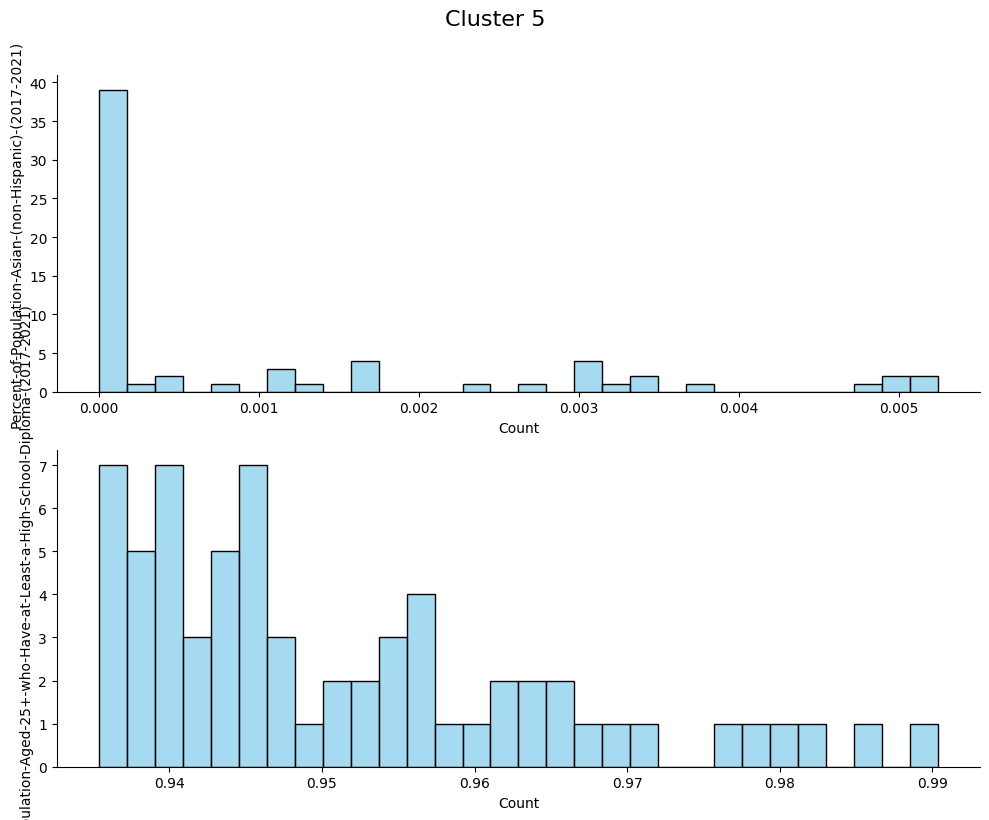

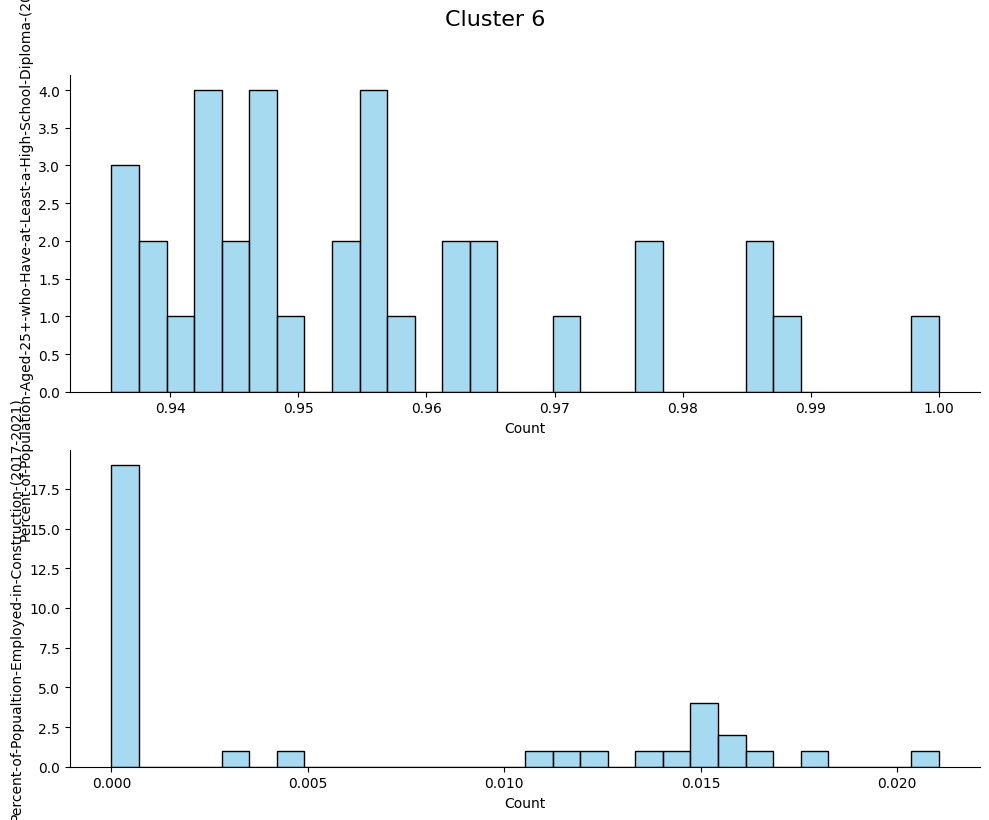

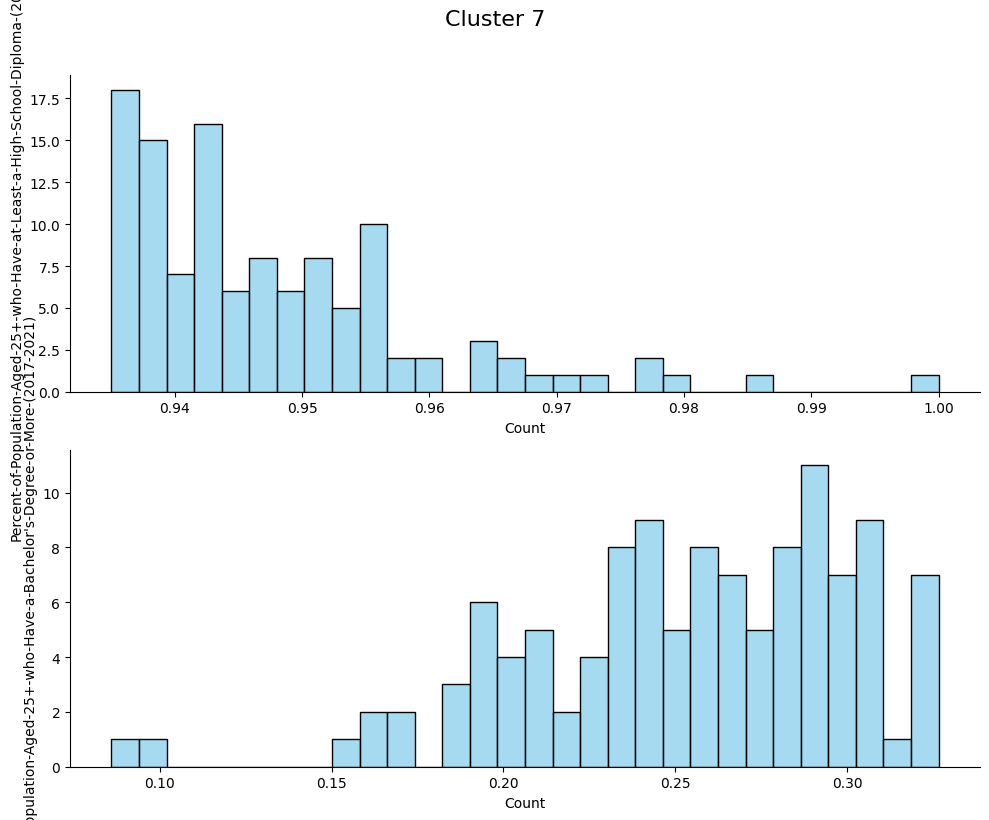

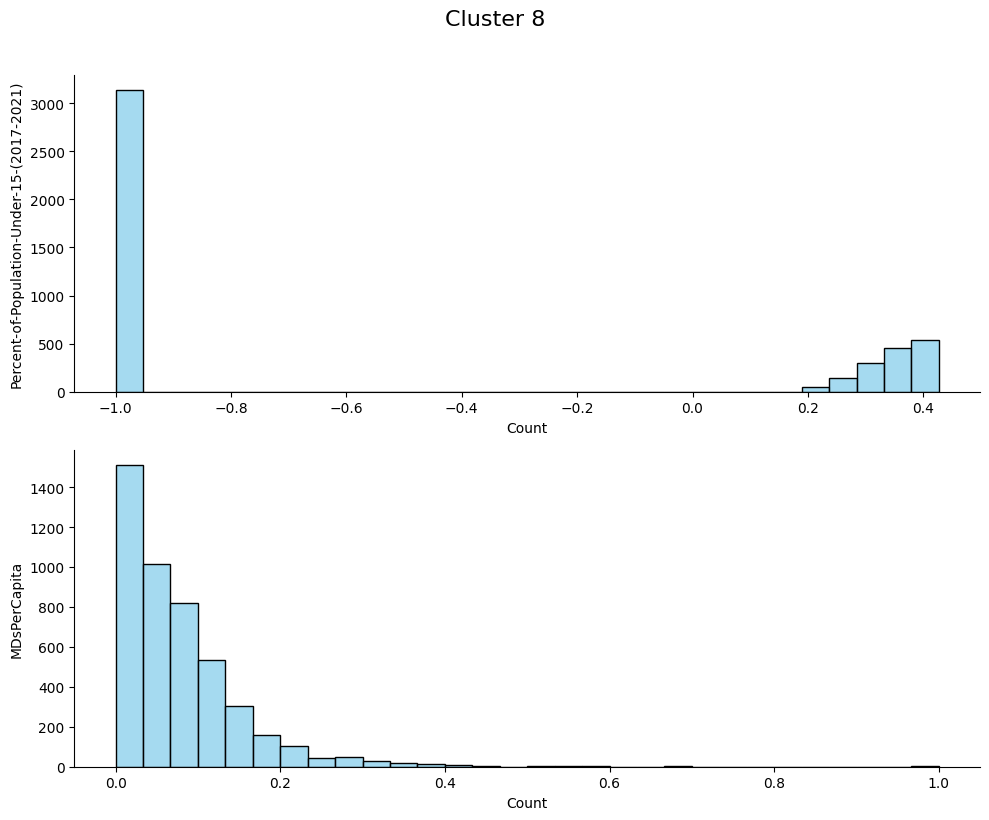

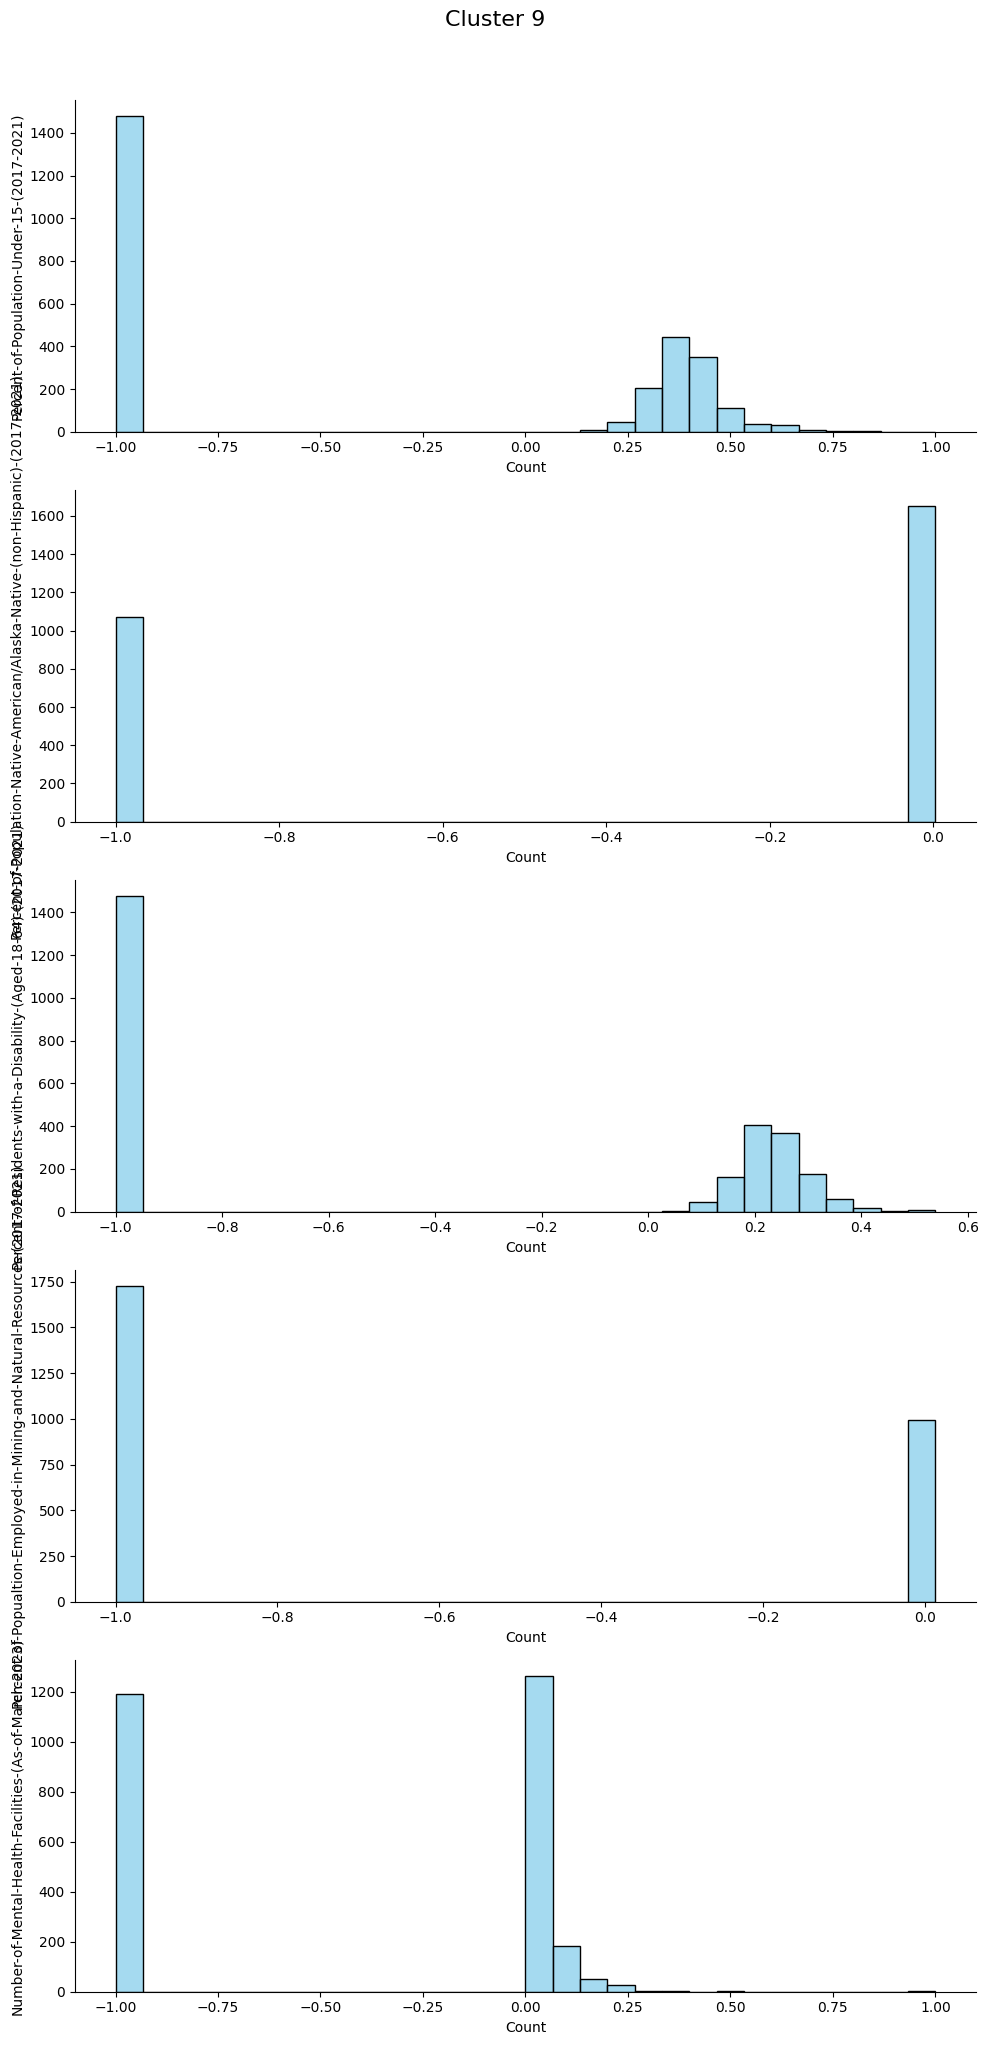

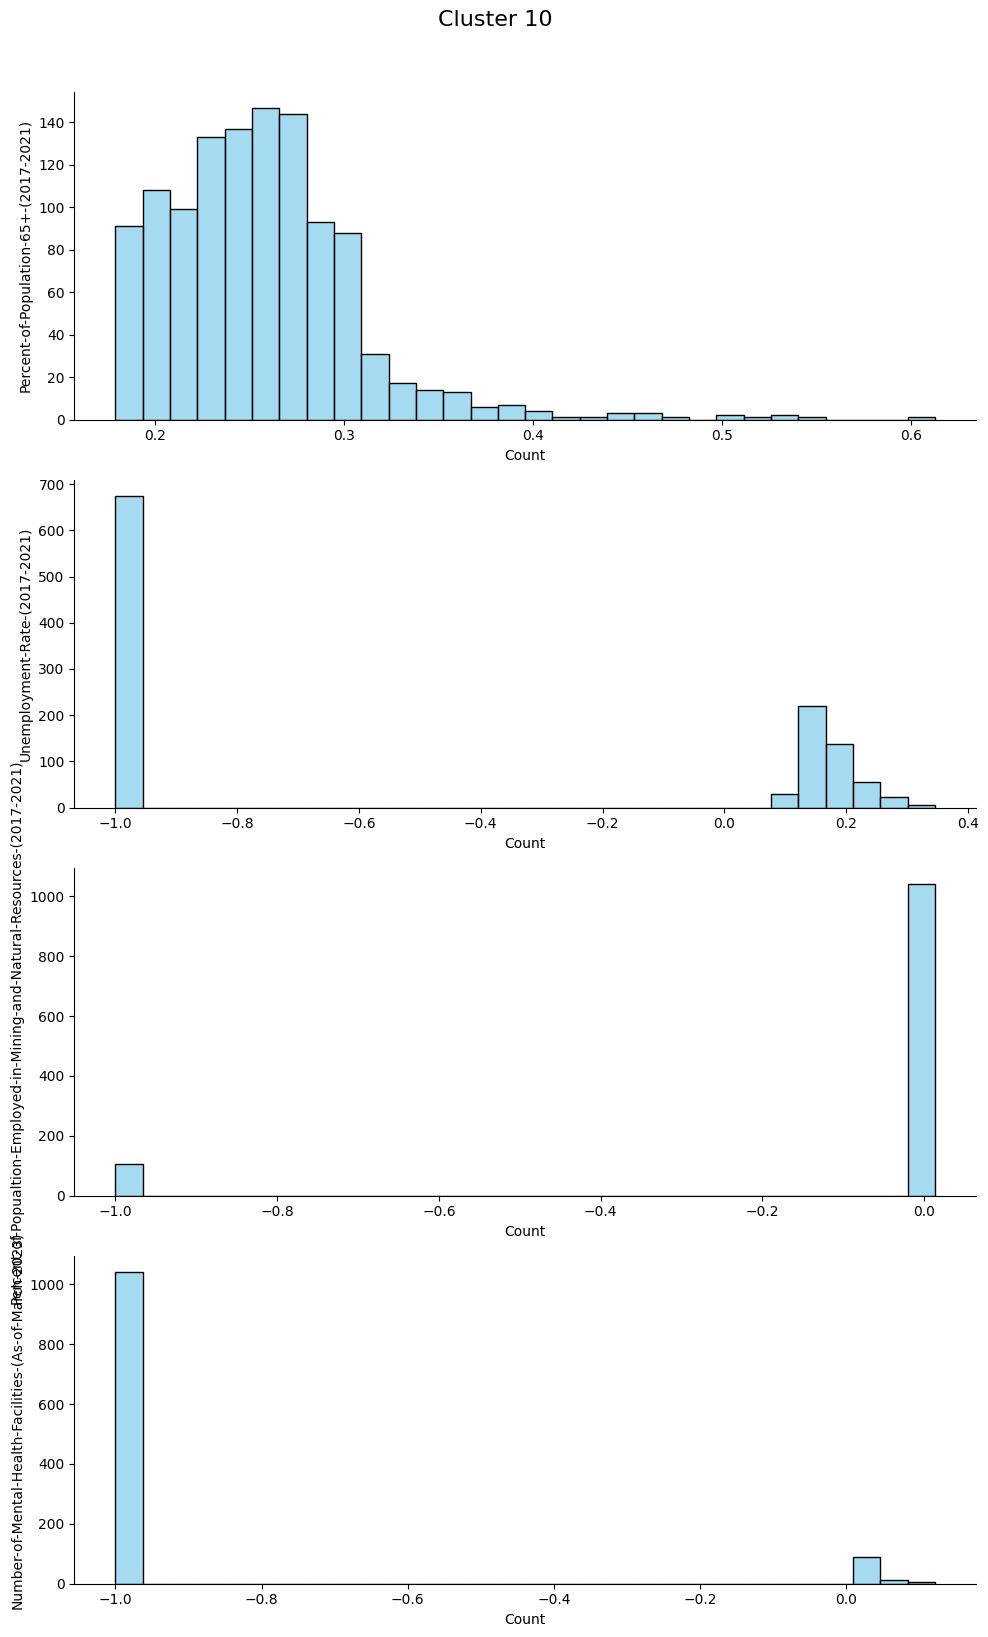

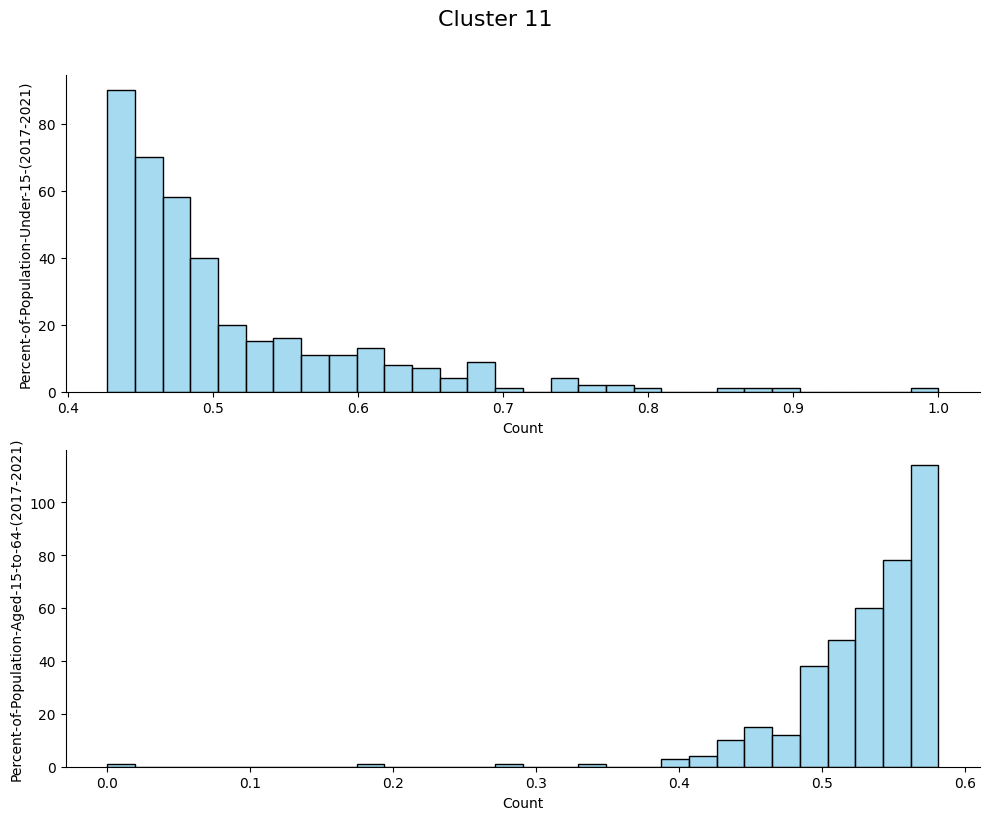

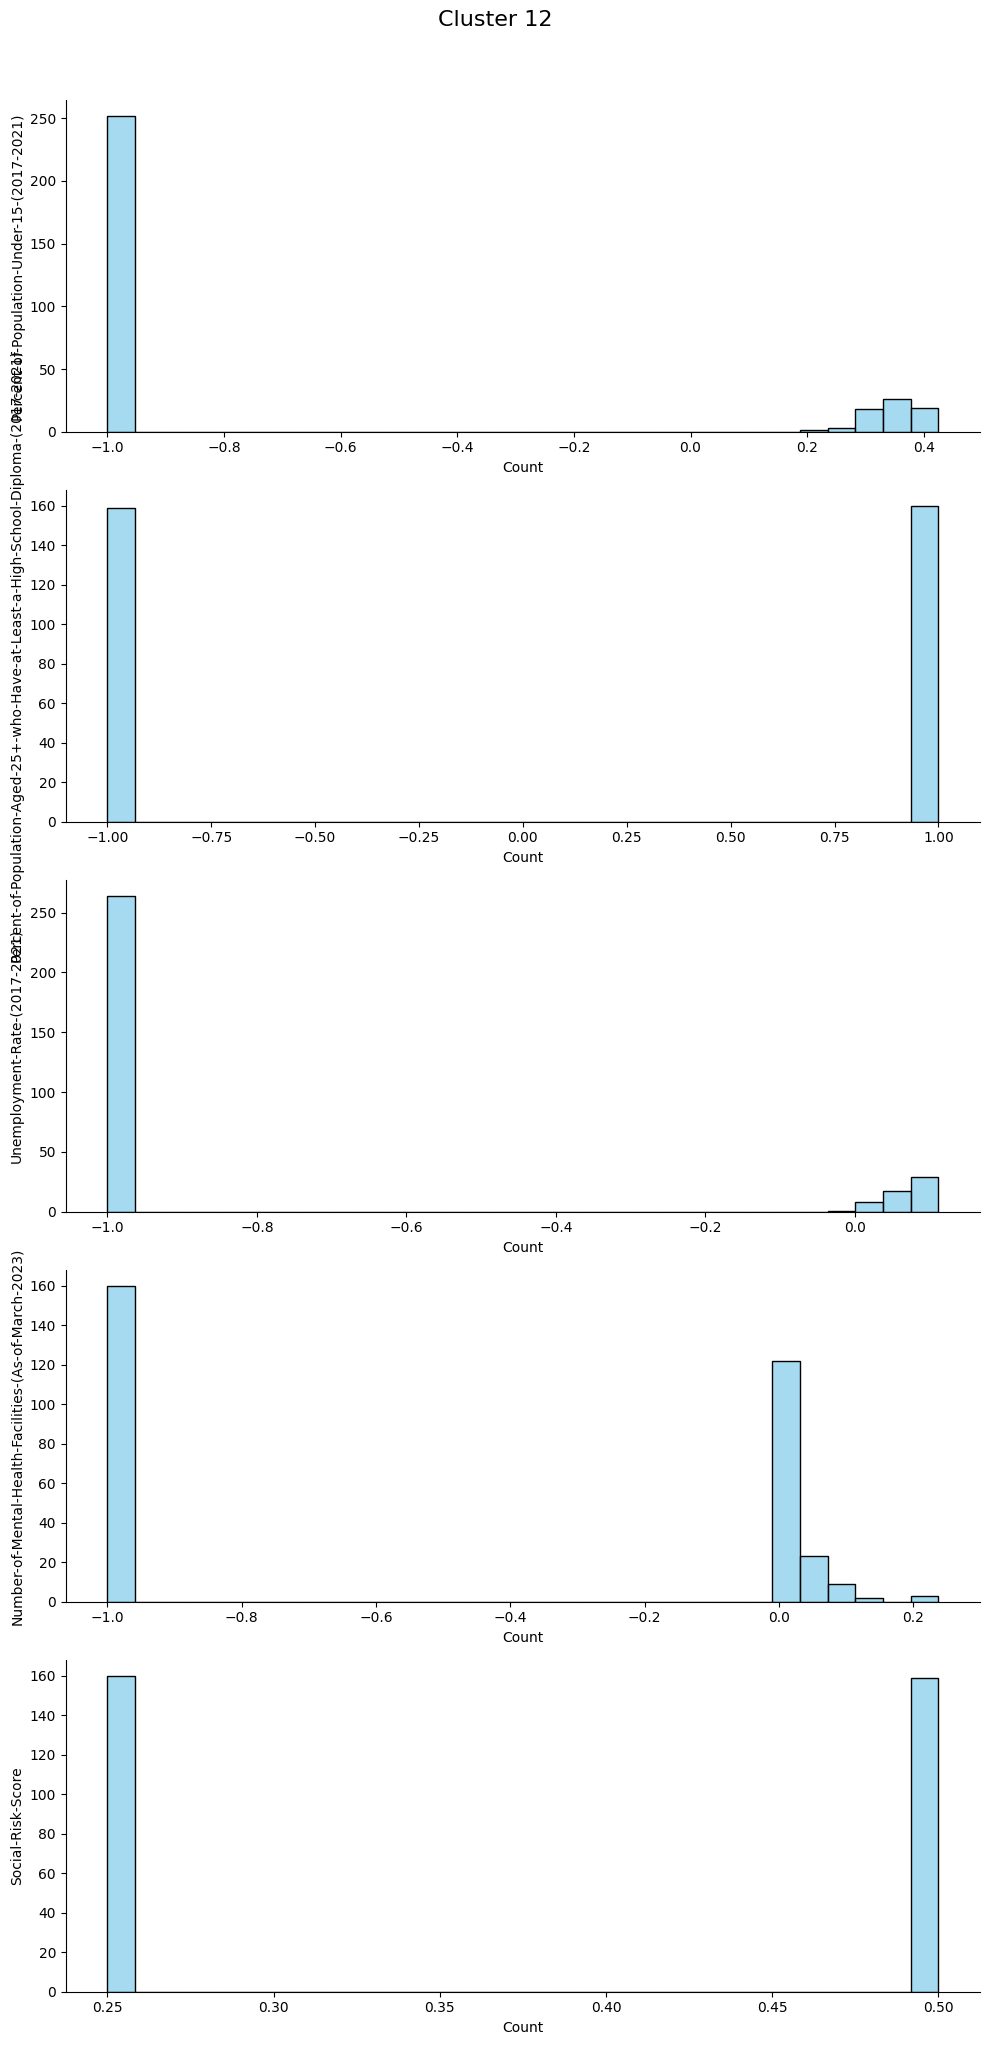

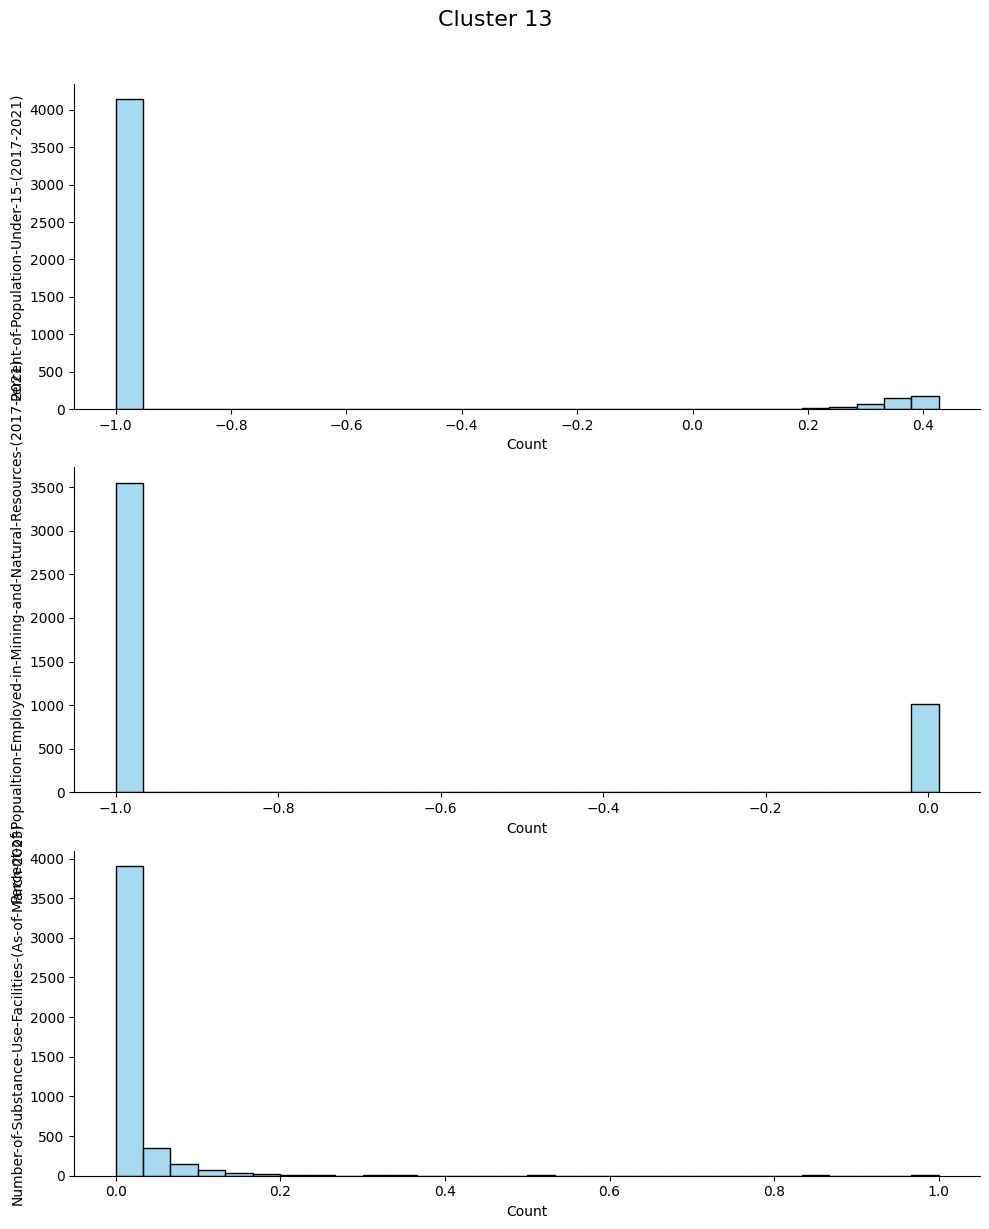

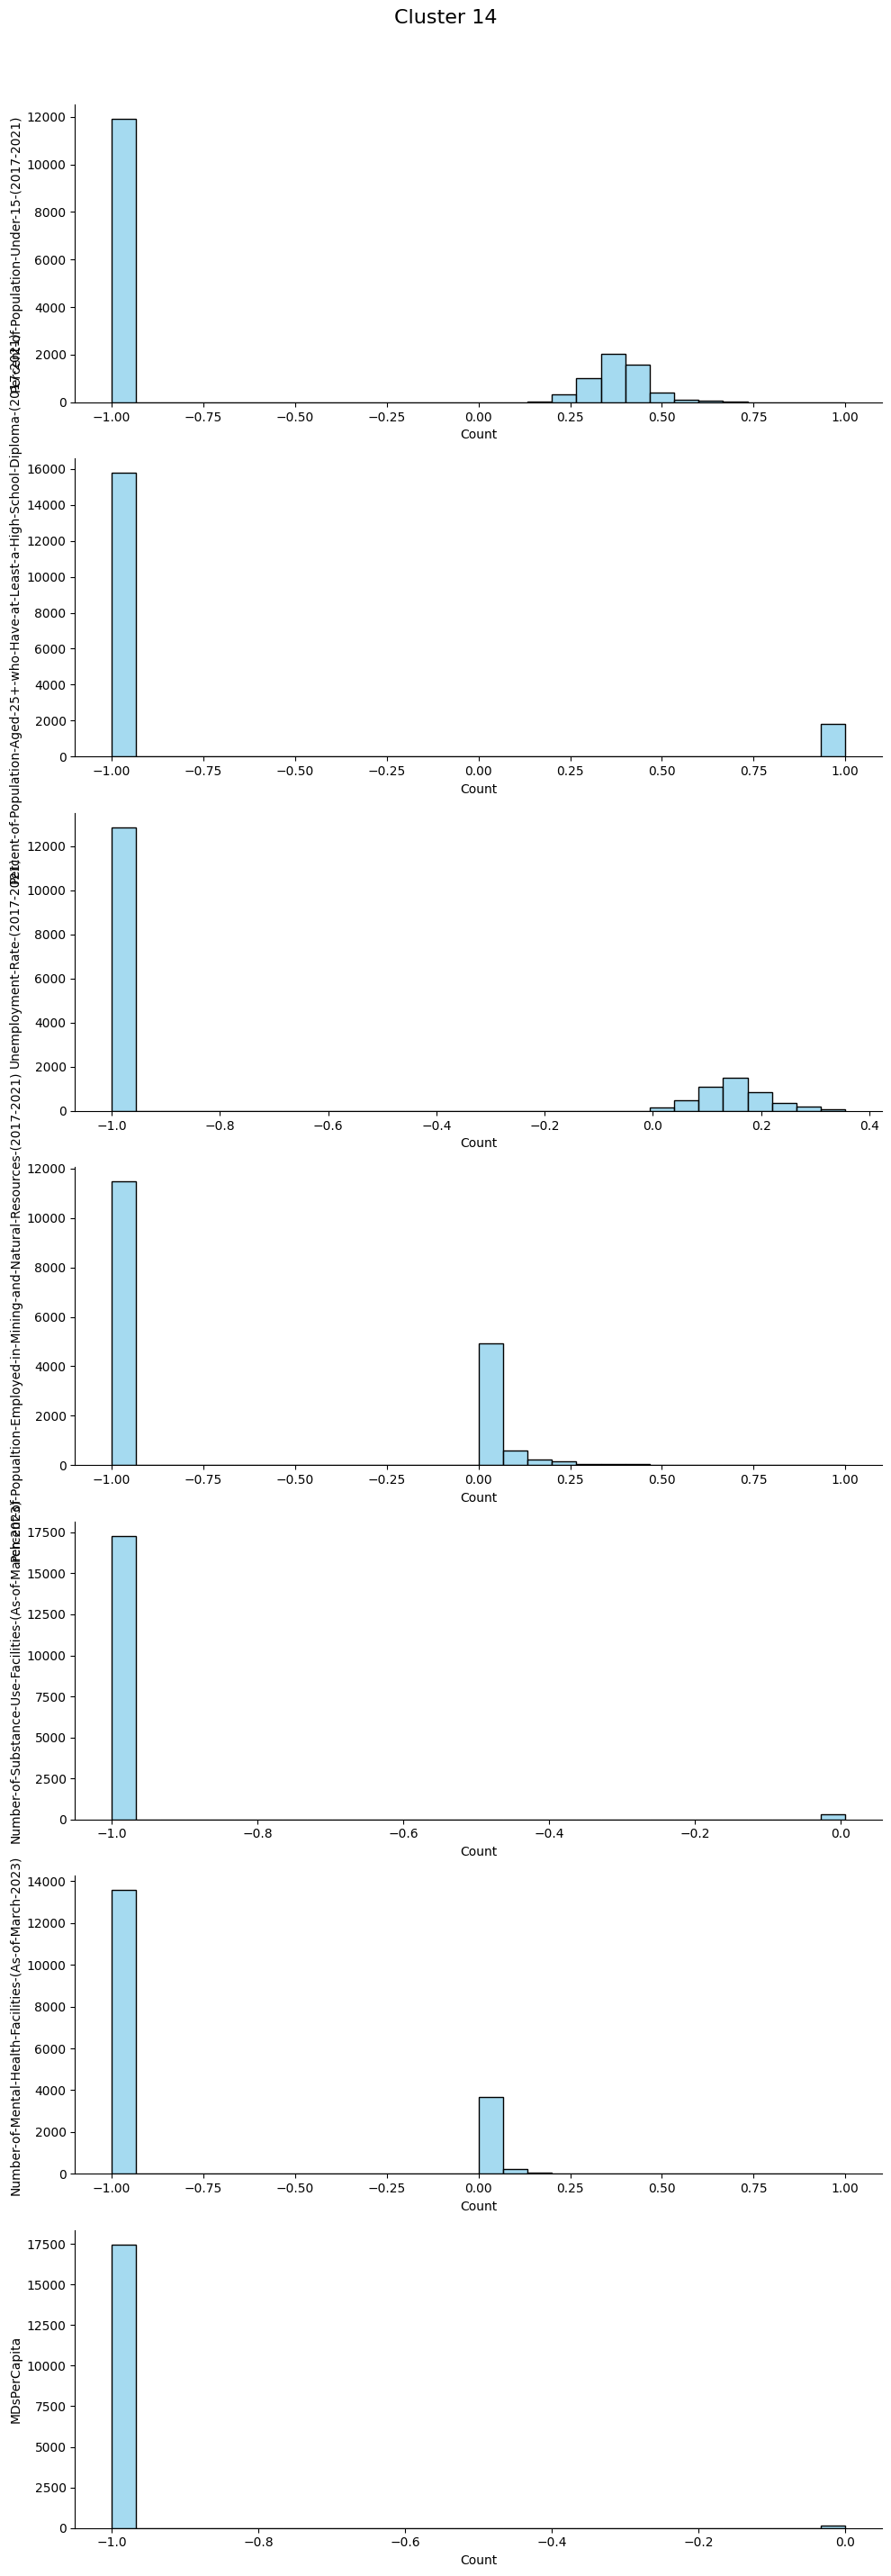

In [ ]:
# After the previously provided code, insert this cell.

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that the cluster labels and df are defined from the previous steps
# df should have cluster_label column and feature_columns list should be defined.

for cluster_num in sorted(df['cluster_label'].unique()):
    cluster_df = df[df['cluster_label'] == cluster_num][feature_columns]

    # Filter features that have a non-zero range
    cluster_min = cluster_df.min()
    cluster_max = cluster_df.max()
    non_zero_range_features = [f for f in feature_columns if (cluster_max[f] - cluster_min[f]) != 0]

    if len(non_zero_range_features) == 0:
        continue  # If no features have a non-zero range, skip this cluster

    # Create a figure for this cluster
    fig, axes = plt.subplots(nrows=len(non_zero_range_features), ncols=1, figsize=(10, 4 * len(non_zero_range_features)))
    fig.suptitle(f"Cluster {cluster_num}", fontsize=16, y=1.02)

    # If there's only one feature, axes won't be an array
    if len(non_zero_range_features) == 1:
        axes = [axes]

    # Plot each feature as a histogram
    for ax, feature in zip(axes, non_zero_range_features):
        # Plot a horizontal histogram of the feature values in this cluster
        sns.histplot(cluster_df[feature], ax=ax, kde=False, bins=30, orientation='horizontal', color='skyblue')

        # Set y-axis label to feature name
        ax.set_ylabel(feature)
        # Set x-axis label to "Count"
        ax.set_xlabel("Count")

        # Remove top and right spines for aesthetics
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


## Results Export
Saving analysis results and visualizations:
- Exporting cluster assignments
- Saving visualization PDFs
- Generating cluster statistics


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the name of the PDF file to save
pdf_filename = "cluster_histograms.pdf"

with PdfPages(pdf_filename) as pdf:
    for cluster_num in sorted(df['cluster_label'].unique()):
        cluster_df = df[df['cluster_label'] == cluster_num][feature_columns]

        # Filter features that have a non-zero range
        cluster_min = cluster_df.min()
        cluster_max = cluster_df.max()
        non_zero_range_features = [f for f in feature_columns if (cluster_max[f] - cluster_min[f]) != 0]

        if len(non_zero_range_features) == 0:
            continue  # If no features have a non-zero range, skip this cluster

        # Create a figure for this cluster
        fig, axes = plt.subplots(nrows=len(non_zero_range_features), ncols=1, figsize=(10, 4 * len(non_zero_range_features)))
        fig.suptitle(f"Cluster {cluster_num}", fontsize=16, y=1.02)

        # Ensure axes is always a list
        if len(non_zero_range_features) == 1:
            axes = [axes]

        # Plot each feature as a histogram
        for ax, feature in zip(axes, non_zero_range_features):
            sns.histplot(cluster_df[feature], ax=ax, kde=False, bins=30, orientation='horizontal', color='skyblue')

            # Set labels
            ax.set_ylabel(feature)
            ax.set_xlabel("Count")

            # Remove top and right spines for aesthetics
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        plt.tight_layout()

        # Save the figure for the current cluster to the PDF
        pdf.savefig(fig)
        plt.close(fig)

print(f"All cluster histograms have been saved to {pdf_filename}.")


All cluster histograms have been saved to cluster_histograms.pdf.


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

# Filepath for saving the PDF
output_pdf_path = 'cluster_histograms_with_titles.pdf'

# Create a PdfPages object to save multiple pages into a single PDF
with PdfPages(output_pdf_path) as pdf:
    for cluster_num in sorted(df['cluster_label'].unique()):
        cluster_df = df[df['cluster_label'] == cluster_num][feature_columns]

        # Filter features that have a non-zero range
        cluster_min = cluster_df.min()
        cluster_max = cluster_df.max()
        non_zero_range_features = [f for f in feature_columns if (cluster_max[f] - cluster_min[f]) != 0]

        if len(non_zero_range_features) == 0:
            continue  # If no features have a non-zero range, skip this cluster

        # Create a figure for this cluster
        fig, axes = plt.subplots(nrows=len(non_zero_range_features), ncols=1, figsize=(10, 4 * len(non_zero_range_features)))
        fig.suptitle(f"Cluster {cluster_num}", fontsize=16, y=1.02)  # Add cluster number as the title

        # If there's only one feature, axes won't be an array
        if len(non_zero_range_features) == 1:
            axes = [axes]

        # Plot each feature as a histogram
        for ax, feature in zip(axes, non_zero_range_features):
            # Plot a horizontal histogram of the feature values in this cluster
            sns.histplot(cluster_df[feature], ax=ax, kde=False, bins=30, orientation='horizontal', color='skyblue')

            # Set y-axis label to feature name
            ax.set_ylabel(feature)
            # Set x-axis label to "Count"
            ax.set_xlabel("Count")

            # Remove top and right spines for aesthetics
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure to the PDF
        plt.close(fig)  # Close the figure to free up memory

print(f"Histograms with cluster titles have been saved to {output_pdf_path}")


Histograms with cluster titles have been saved to cluster_histograms_with_titles.pdf
